# Beer draft modelling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from tqdm import tqdm_notebook
import random as random

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
from sklearn.model_selection import cross_val_score, train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, precision_recall_curve, r2_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

In [3]:
from my_classes import Dropper, Dummier, Vectorizer, Stemmer

In [4]:
apa_df = pd.read_csv("../../data/reviews/apa_cleaned.csv")

In [5]:
apa_df.head()

,rating,look,smell,taste,feel,overall,review,date,id,name
0,3.95,4.0,4.00,4.00,4.00,3.75,Finally getting around to trying this one. Hap...,2019-10-22,276,Sierra Nevada Pale Ale
1,4.92,5.0,4.75,5.00,4.75,5.00,The Sierra Nevada Pale Ale is the BEST “standa...,2019-10-18,276,Sierra Nevada Pale Ale
2,3.84,4.5,3.00,4.00,4.50,4.00,"From the back label of the bottle: ""PKGD 07/22...",2019-10-17,276,Sierra Nevada Pale Ale
3,3.68,3.5,3.50,3.75,3.75,3.75,Poured from a 355ml bottle. It has a dark gold...,2019-10-14,276,Sierra Nevada Pale Ale
4,4.00,4.0,4.00,4.00,4.00,4.00,This beer took me a while to warm up to. I use...,2019-10-07,276,Sierra Nevada Pale Ale


In [6]:
apa_df.describe()

,rating,look,smell,taste,feel,overall,id
count,17349.000000,17349.000000,17349.000000,17349.000000,17349.000000,17349.000000,17349.000000
mean,3.847477,3.914798,3.806233,3.848252,3.843569,3.869291,68297.891982
std,0.507472,0.500440,0.570200,0.577121,0.540289,0.541931,63931.274590
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,39.000000
25%,3.570000,3.500000,3.500000,3.500000,3.500000,3.500000,10365.000000
50%,3.900000,4.000000,4.000000,4.000000,4.000000,4.000000,59192.000000
75%,4.190000,4.250000,4.250000,4.250000,4.250000,4.250000,91566.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,315536.000000


In [7]:
#setting my binary rating at about the median
apa_df["rating_bin"] = apa_df["rating"].apply(lambda x: 1 if x > 3.9 else 0)

### Baseline

In [9]:
#checking baseline accuracy
baseline = apa_df["rating_bin"].value_counts(normalize=True).max()
baseline

0.5068303648625281

### Logistic

In [24]:
#setting X and y, and creating split
X=apa_df.copy()
y = X.pop("rating_bin")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

#Setting up pipeline classes
dropper = Dropper(["look", "smell", "taste", "feel",
                    "overall", "date", "id", "name", "rating"])
vec = Vectorizer(to_vec = "review")
model = LogisticRegression(solver = "lbfgs")

#Setting up pipeline
log_pipe = Pipeline(steps = [("dropper", dropper),
                              ("vec", vec),
                              ("model", model)])

#Fitting and scoring model
log_pipe.fit(X_train, y_train)
scores = cross_val_score(log_pipe, X_train, y_train, cv=5)

print("CV score: {0:.3f}".format(np.mean(scores)))
print("CV std = {0:.3f}".format(np.std(scores)))
print("")
print("Test score: {0:.3f}".format(log_pipe.score(X_test, y_test)))

CV score: 0.773
CV std = 0.008

Test score: 0.770


In [25]:
log_coeffs = pd.DataFrame(zip(log_pipe.steps[1][1].feature_names, log_pipe.steps[2][1].coef_[0]), columns = ["feature", "coeff"])
log_coeffs.sort_values("coeff", ascending=False).head(15)

,feature,coeff
8216,great,4.710707
6645,excellent,4.658625
5152,delicious,4.547273
6910,fantastic,4.037971
9869,juicy,3.621700
13115,perfect,3.420420
19785,wonderful,3.336082
10935,mango,2.998802
18473,tropical,2.991370
1923,beautiful,2.755903


In [21]:
for i in range(0,apa_df["review"].str.contains("dank").sum()):
    print(apa_df[apa_df["review"].str.contains("dank")].iloc[i,0])
    print(apa_df[apa_df["review"].str.contains("dank")].iloc[i,6])
    print("")

4.04
Waited to try this beer for years and then kind of forgot about it. Suddenly it appears on local shelves. It is pretty good for only having the terrible Citra hop being used (I am sorry but Psuedo Sue is terrible). I would describe this as the original juicy pale ale before the haze craze came along. It also has the benefit of having bitterness and not being overly sweet. Would I drink this regularly? Probably not as I am more in the pine, herbal, earthy, dank spectrum with hoppy beers.

4.33
Appearance: Pours a glowing, but not bright,orange/amber color like an ember from a dying campfire. Aroma: Strong citrus aroma of mandarin orange, ripe pineapple, grapefruit. A dank pine forest. Flavor: Tons of nice mandarin orange, grapefruit, ripe pinapple with a dank and resiny pine flavor. A somewhat sweeter honey (maybe toffee?) bread malt body follows. A wave of bitterness finishes on the end.  Feel: Medium body, but a heavier mouthfeel. It captures the IPA level of hop flavor bitter as

Look - a slightly opaque golden orange with a one-finger white head that sticks around and has decent lacing throughout. Smell - dank pungent hops are front and center, but you also get a nice array of hop aromas in the form of citrus (grapefruit, lemon, orange) and floral notes. There are also some sweet notes lingering in the background that might be caramel malts. Taste - very similar to the nose in that dank resin, earthy hops are very powerful, but it's balanced with the lighter side of the hop spectrum since the citrus and floral notes (like mentioned above) shine through. Again, there's a slight malty presence in the form of caramel and bread, but these notes are almost completely overpowered by the thick hop characteristics.  Feel - high carbonation, medium body, sticky mouthfeel. Overall, this is definitely an interesting example of the style. It tastes more like an imperial IPA, but it still maintains aspects of a lighter, refreshing pale ale. It's a hop bomb for sure, which 

Hazy amber orange color with a thick two finger head with good retention and leaving some laces. Superb hoppy aroma with notes of mango, lychees, fresh orange-lemon zest, clean pine, grapefruit, pineapple, flowers and bread. I am hungry, so more nose sensitive and easier to imagine this fresher. Flavor with notes of green tea, lemongrass, a bit of mango, ginger, pine, white pepper, sweet flowers, grapefruit, lemon and tangerines. Dry aftertaste with a very delimited bitterness. Light body with perfect carbonation of the tiniest bubbles given a somewhat velvet feeling. Relatively potent at 6.8% abv for and APA which is completely absent. World class APA with lots of dank and green diversity side by side zesty citrus notes. Clean and crisp as it can be. I was expecting a high bar which was delivered accordingly.

4.23
Pours a medium gold/light amber coloration with a medium, fizzy head. Smell is quite hoppy, with light biscuity malt. Notes of citrus/tropical fruit, with orange and tanger

CAN Sticky snow cream over hazy brass. 4 Orange rind, sugared grapefruit, and dank. 4 Thread of cracker and Children’s Bayer to start, slight toffee, a bit dirty, blooms into big papaya, lemondrop, grass, and flowers, then tight lemon rind bitter leave. 4.25 Scratchy linger.  Light, oily, round. 4.25 11.16 canning, 12.21 drinking. When it’s cold, it comes across thin and underhopped - APAs suffer compared to Session IPAs these days. But it thickens up as it warms, and the lean citrus opens into resin and a ton of orange - an Amarillo fest. Weedy edge to the hopping, smooth enough, crisp - this is also doing a lot of details right that other beers don’t notice, especially at just ~5%.  A shifty, faceted old-school pale ale that rewards repeated visits. 4.5

4.25
From a 16oz can: Appearance: Clear gold, good head. Smell: Citrus and some dank aroma. Taste: Nice balanced breadiness and moderate citrus bitterness. It's hoppy but you definitely get a good malt base. Overall: Picked up a four

Pours a maize color with a white near-fluffy head and lacing. This is the second in a line of five beers and I'm getting an impressive display of hop freshness so far. Tangerine, passionfruit and dank hops on the nose translates to fresh dew, biscuit or saltine cracker and a hint of lime on the tongue. The bitterness builds a bit, but at the end of the night, I think this is my favorite of Maine's offerings.

4.52
Maine Beer Co puts out so many refined, spot on beers it's almost mind blowing, and MO meets every standard they've set for their offerings. Pours a light golden brown with a skinny white head of foam. Smells clean and crisp, some citrus, slight hit of dank pine. Taste is sweet malt followed by fresh bursts of citrus fruit. Carbonation is spot on.

3.45
Bottle dated 6/4/15 so it's about a week past its drop dead date. I really like APAs, but this one doesn't float my boat. I don't get any citrus, not much floral, some dank, bitter pine but that's about it. It's nice and light

Pours a crystal clear brass hue, with a winger of sudsy off-white head. Beautiful streams of effervescence streaming up from the bottom, keeping that head alive. Nose is wonderfully big, bright, vibrant fresh hops. Oddly enough, reminds me of lupulin. Green and fresh with that creamy, almost coconut vibe. Smells a touch like Lawson's. Definitely some signature Lagunitas grapefruit action, but also some sweetness and earthy dankness from mosaic. Palate - That's a yummy one. I've been drinking Tree House exclusively for the last week, so big change of pace here, but can definitely appreciate it. It opens up bright and crisp, and then a slightly unpleasing metallic note chimes in, but then a big dankness takes over, getting danker and danker, until the bright citrus tines it opened up with are but a mere memory. There's some light biscuit malt in the very back end, but the hops are the star here. I get some mosaic in the very beginning, with some melon and berry, but it gets really earthy

O: This one is a bit rough around the edges, but I'm not sure if the off flavors are intentional or due to the two and a half months it sat in it's box. Regardless, this is a surprisingly good pale ale.

3.67
Bottle dated 118A16 (Aril 28, 2016?) DFH Tulip. A (3.5): Pours a hazy copper-amber with just under 1 finger off-white head. Very little visible carbonation. Retains a thick ring of white around the edges and a large island of foam and a couple of bubbles in the middle. Leaves a few trails of lacing on the glass. S (4): Smells like cascade hops! And a good dollop of malt. Kind of a sweet orange marmalade thing going on. There is a distinct cascade smell of orangey dankness. I really enjoy the smell of this beer. T (3.5): Dry, balanced arrival. Mid palate fills your mouth with light, bready malt and cascade hops. Malt with a good bit of piney dankness at the end. Website says it has some Northern Brewer, Simcoe, and Citra. The Northern Brewer would explain that dankness at the end. 

Dated 5/9/18 on the bottom of the can, 12 days since brewing. Pours a nearly opaque straw-gold with a finger and a half of compact white head. Aromas bursting out of the can as soon as I cracked it open. First notes of the nose are of spices; pepper, coriander and cumin. This is followed by ruby grapefruit pith, black licorice, honeydew and a selection of over-ripened tropicals (mango, apricot, pineapple). Taste follows the nose with the over-ripened fruit and spices, but also brings in some dankness, pine resin and pale grainy malt. Body is a smooth medium- with low dryness and a medium- hoppy bitterness. Another great IPA from Trillium, perfectly balanced and smooth, Great blend of hops that give mix of pungent spices, tropical fruit and hoppiness.

4.11
16oz can in a stemmed tulip glass. A careful pour yields a hazy glass-beaded orange color with a 1f white cap. The head tapers to a lasting film and leaves some foam lacing. Hop aromas spill into the air; citrus, orange, tropical pin

Bottle poured into a Lagunitas mason jar A: Pours golden orange amber with a frothy off white head that settles to a firm layer and laces very nicely. S: Citrus instantly countered with dank herbal notes, pine, hints of tropical fruit, biscuity malt, and caramel sweetness. T: Dank herbal notes, citrus, grapefruit, orange, and lemon, pine, just a hint of tropical fruit, papaya, mango, and pineapple, biscuity malt, and caramel sweetness.  M: Medium body, moderate carbonation. O: Classic old school Lagunitas. Really solid pale ale.

4.6
L: Clear golden orange with a massive foamy white head. Excellent retention, sheets of lacing. S: Orange and grapefruit zest, citrus oils just ripping into your nostrils, like freshly shredded orange peels. Intensely zesty and zippy. Smells dank and grassy...not unlike marijuana, as well. A bit of biscuity malt backbone and typical Lagunitas chemical/rubber, but mostly huge ripping citrus and weed. T: Follows the nose exactly. Enormous fresh oranges and gr

Bomber into a snifter. Aggressive pour. Nice hazy gold/orange. Big, pillowy off-white head of foam. Smells awesome; sweet fruit, grapefruit, pineapple, strawberries, candied sugar, and peppermint. Honestly one of the best smelling beers I've had. Medium weight and rich, creamy mouthfeel. Tastes a bit similar to a couple of their other PA's, but still good. I get pine, citrus, and notes of grapefruit, orange, and berries. Dry finish with a bit of a dank, tart aftertaste. This is a good beer, but I feel like it's strangely similar to Yum Yum. Maybe it's the a certain type of hops the two share, or something. But I enjoyed Yum Yum, and I enjoyed this. This one had a bit of the same funky taste, which I didn't care for. Not sure what specific ingredient or brewing technique attributes to this, but if anyone knows what type of hops SSMF, Yum Yum, and Alpha King are made with, I'd be curious to know. While this is good, I'm not sure I could tell the difference between this and another 3F PA 

Appearance: Pours a slightly clear, light golden color with a mild white head that fades quickly. (3.5) Aroma: Strong aromas of tangerine, blood orange, grapefruit, and pineapple. Maybe some mango and dank tropic notes underneath. Can't get much of a malt profile with the stronger hops. (3.75) Flavor: Huge blood orange, grapefruit, and tangerine flavors. Light pineapple. A crystal malt sweetness in the middle, but it finishes relatively bitter with a pithy pineapple and citrus note. All fruit here. Flavors similar to an orange staburst, and orange soda, or an orange CapriSun. Crystal malt sweetness and pithy fruit finish. (3.75) Feel: Medium bodied. Well-carbonted. Crispy actually. A little grain, but not much. A pithy bitterness is left on the tongue. (3.5) Overall: Yes, this is a good beer. I can't really judge it as a pale ale, but rather an IPA. Tremendous flavor for a pale ale, but for a 7.5% IPA, I wouldn't say it's mind blowing. Also how can a pale ale have such high alcohol. I 

Galaxy is quite a hop and this beer is loaded with it. Smells like tropical fruit juice when you open the can. The taste is tropical fruit forward followed by weedy dankness and a long lightly bitter finish. yb

4.54
Somehow this one has eluded me for all this time. Canned 1/04/17, "some creedence tapes" says the quote, I wouldn't put any hope in getting the Creedence back. Pours a huge fluffy frothy 2 finger head that fades at a med pace, sticky lacing, super murky milk shake tangerine color. Nose loads of tangerine and citrus juice, clementine, a little pithy, faint grapefruit, maybe a touch of pineapple, some tropical notes with a little dankness, orange bubblegum and orange cream, getting a big pith, little papaya, some mango. Taste brings loads more citrus and some dank tropical fruits, a hint of maybe pine but that gets drowned quickly by citrus, orange juice, a little rind, some pith, clementine, some grapefruit, some pineapple and papaya, some mango, fair bitterness, a little g

Reviewed from notes from 1/9/13 A- Pours a slightly hazy golden/straw color with a small to medium sided head with decent retention.  S- The aroma is very grassy and piney, with a bit of freshly baked bread. A hint of caramel malt appears as it warms. Overall a very clean, fresh, and refreshing aroma. T- The taste follows the aroma very closely, with dank/grassy hops taking the forefront, a healthy dose of pine and toasted bread in the middle (as well as caramel malt as it warms), and a snapping, yet refreshing bite of hop bitterness in the finish.  M- The mouthfeel is medium with good carbonation.  O- This is one of the best APAs I've had to date!

3.01
Pours beautiful copper/gold with nice inch of white foam. Nose is bold, grassy, funkiness. Some citrus peel and melon are detected as well. The flavor definitely picks up that dank grassiness in a big overwhelming way. There is some fruitiness in the finish as well. Mouthfeel is decent with good amount of carbonation. IMO it drinks hea

From a growler, pours a clear orange-gold. Two fingers of white foam leaves a bit of lacing. Smell has lots of fresh pine, along with citrus and a touch of earthy herbs. Taste is piney and dank, with a nice herbal spiciness and a very dialed in bitterness. May be one of the most flavorful 5.5% beers I've had. Gotta say I love this beer. Has all the flavor of a really good West Coast IPA, but doesn't hammer you with a high ABV.

4.2
Refreshing. This is my favorite of the BP offerings I have had thus far. It's definitely a hop-heavier pale leaning toward the IPA side of things, but with less complexity and more instantly refreshing qualities. I like how dank/resinous it is without it being heavy. Great all day ale.

3.82
12oz bottle - aaah, grunion is a kind of fish, got it. This beer pours a clear, medium copper amber colour, with four fat fingers of puffy, rocky, and mildly creamy off-white head, which leaves some streaky and sudsy lace around the glass as it lazily recedes. It smells 

Was expecting a bit more from this since Maine Beer Co always seems to deliver. Still a great beer all in all. Looks is semi cloudy, straw yellow. The oat gives it a look similar to a heffe. Nice lingering head and lacing. Smell is very light citrus and grass, not much in this aspect although lacking still pleasant. Taste is heavy lemon and orange fruit and zest, some light dankness as well. Mouth feel is light and fluffy with decent carbonation. All in all a decent beer, I would buy again.

4.14
A: Lemon chiffon body, pith white head. Spotty lacing.  S: Peachy-apricot. Light tones of mint. White fleshed fruit. A tad spicy, lemongrass.  M: Smooth. Crisp. Light.  T: Lemon peel, grapefruit juice. Tangerine sweetness moderated with some grassy hops. Woodsy tartness. Too Light a feel for an APA, but dank citrus hops have an awesome 'mossy' flavor. Green, fresh and crisp. Everything works well together here.

3.95
Basic finger’s worth of bright white foam, airy and openly knit so the retent

Russian River Row 2, Hill 56 Straight from the growler, I first had this beer up at the brewery for the Pliny the Younger release and HAD to have more, so a big thanks to my friend NoSignsOfPain for delivering me a fresh growler after her trip up for the Beatification release. This is a single hop pale ale, showcasing the Simcoe hop grown in the Pacific Northwest. The beer pours a nice clear faint copper color, hints of orange when held to the light, a nice finger of soapy head sits atop the beer that has fair retention but leaves behind some nice sticky lacing around the glass. The aroma is extremely dank and very resinous. Big sticky pine, what I can only describe as cat pee with some bright citrus at the end, that is cut very well with some rich bready malt. The aroma is so pungent and just bursts out of the glass, really shows off the Simcoe hop. The flavors are great, big pine presence, nice grapefruit and something more tropical papaya with a really dry bitter dirty earthiness at

16 oz tall boy can.  poured into HF wine stem. Appearance: Golden orange bodied beer with lots of white chunks of suspended sediment present. Pours a large head which is bone white in color. Great staying power on this beer. Head drops down to thick cap and leaves thick lacing on the glass. Smell: Lots of sweet oranges in the hop profile from the Columbus hops. The mosaic adds a nice dank kick to the hop profile. Signature trillium house yeast. Smells fantastic. Taste: On point with the nose. The backdrop of this beer is all sweet oranges and mangos with a dank mosiac hop kick. Light bitterness throughout the beer with light lingering bitterness in the finish.  Mouthfeel: light bodied beer with moderate carbonation. Creamy carbonation present. This beer has a juicy and oily character that makes for a luxurious feel on the palate, but it adds more body to this pale ale. I would prefer this to be more drinkable. Still a fantastic mouthfeel though. Overall: Trillium makes some fantastic h

Traded for this a long time ago, as the date on the bottom of the can read 12/21/16. Yes, I know this was old but it poured decently and only had a hint of sediment floating at the bottom of the liquid. Much of this turned into a malt bomb for me but even the flavors that I was able to discern weren't quite like the beer's stated profile. Thankfully, this was easygoing and easy to drink during a night where I was going through a lot of older stuff in my basement! The pour and appearance were the best aspects of this beer as the cloudy, goldenrod hue, massive fluffy head, and thick, rocky sheets of lacing left behind were all quite pleasing and complementary to each other. Lots of lemon, spice, banana, and tangerine juice in the muted nose as the citrus came out more in the taste. A strong floral taste came through as this fully warmed up as this felt a bit Belgian in tone although there wasn't a ton of funk or farmhouse spice to be had. Slick like citrus juice, there was some mild dank

22oz bomber to my FW Imperial Nonic glass Notes taken on 06/12/2015 A: The Equinox pours a light amber body that looks the color of caramel candy. A touch of hop haze strikes across the body and a massive ecru head forms over top. Displays some impeccable stay power here while a few clumpy swaths of lace are left tracking behind in intervals.  S: Juicy herbals and tropical fruits like tangerine with kiwi come together with a light spice and spikes of melon and grapefruit. There is some underlying pale malt sweetness to this but it’s not at all obtrusive. Becoming more and danker to me with a lemony herbal quality and a touch of medicinals mixed in. Very solid aromatics with a fresh tropical fruit vibe. T: A super easy drinker with some big hop flavor. Hits first with a resinous musky herb note, citrus juice, grapefruit zest, white melon, and tropical flowers. Malt plays the supporting role here with a light spur of toasted grains to help hold it all together. Very smooth overall with t

Straw and cloudy with some carbonation, topped with 4 fingers of fluffy, off white head. Smells of green leaf, dank hops, pineapple, yellow jello, biscuit umami, peaches and lemon candy. Tastes of biscuit umami, yellow life saver, catnip, green leaf, and slight onion. Light body with a tannic finish. Moderate to low carbonation. Got this on arrival in Redding, CA, drinking here at Motel 6, Aug 4th, 2018. Really good but light beer.

4.21
19 Oz Can poured into glass, Immediately notice a dank strong hop smell, wow Look - It's actually quite colorless, straw-yellow but it has an excellent thick foam head and good lacing Smell - Very strong smelling. Picking up tropical fruits like mango, pineapple-coconut, orange, grapefruit, some sweet grass I'll say this, one of the best smelling beers I have tried.. Taste - Certainly not a light beer but it is lighter than i expected. Tropical hop flavors are there and there is a moderately high bitterness with the classic pine taste. Very drinkable, 

Tulip glass. From one week old Growler. Big thanks to mjord23 for sharing this. A: Pours a cloudy pale/straw color with a few cm of fine, white head. Good retention and minimal lacing. S: Subtle aroma of dank and citrus hops, some floral notes and breadyness, and maybe fruity and crystal malt.  T: Slight citra hoppiness, lemon zest, some breadyness and minerals, very dry and with a mild gripping bitterness on the finish. M: Slightly creamy and smooth mouthfeel on a light body and light carbonation. O: Tasty, subtle flavors for a highly drinkable pale ale. A bit one note-y and lacking in depth/complexity, but that makes it a nice easy drinking/lawn mower beer.

4.64
On tap at Hill Farmstead third anniversary. Pours a pale hay golden with thick creamy head. Aroma is tropical fruits and citrus, flowers and dank resin. Taste is very fruity, moderatly hoppy with a little more malt than I could expect from HF that makes it dangerously drinkable. Very good.

4.29
Had this on 2012-06-09 in Way

It pours super hazy and with an enormous head. The smell is dank and tropical. Full mouthfeel thanks to the oats. A very tasty Pale Ale, full of flavor but also easy to drink.

4.15
Poured from a 64 ounce growler into a 16 ounce chalice at 38F. Purchased at a bottle shop in 11103. Flaked oats. They vastly improve mouthfeel and color. Tired Hands seems to love using them, probably moreso than any other brewery out there. I really prefer the color and texture of flaked oats fermented in ale yeast. Hop Hands is fairly cloudy. Cloudy enough that I cannot see through the glass. And the coloring is light yellow, and kind of reminds me of Carton Boat, which has a similar ABV but a different hop blend. The look of this pale ale is really attractive to me, and I think that the coloring is by far it's best attribute. Nose is piney and fruity. Resinous and bready. Also slightly yeasty.  Taste wise Hop Hands is good. No it's not great, as you will find many better North East Style pale ale's with 

A - nice clear golden amber color with a head that dissipates pretty quickly and therefore doesn't leave much lacing S - nice grapefruit, pine, some dank garlic onion. Passionfruit. T - same as smell, a little more muted though. Grapefruit, pine, dank garlic onion.  M - very light. Alcohol covered. Aftertaste is grapefruit/dank.  O - pretty damn decent, I like it better than the mango version.

4.04
12oz bottle, a very cool new brewery arrival in Alberta. 'San Diego Session Ale' probably means what I think it means. This beer pours a clear, bright medium copper amber colour, with two fingers of puffy, loosely foamy, and well bubbly ecru head, which leaves a hanging band of dripping paint swath lace around the glass as it evenly subsides. It smells of pungent red grapefruit, orange, and sweet lemon citrus, bready, grainy pale malt, a touch of caramel, some hard water flinty notes, a twinge of musty, dank pine resin, and further leafy, weedy, and floral hops. The taste is more mixed dome

12 ounce can into pint glass, canned on 3/29/2018. Pours slightly hazy deep golden amber color with a 1-2 finger fairly dense and fluffy off white head with great retention, that reduces to a small cap that lingers. Nice spotty soapy lacing clings down the glass, with a fair amount of streaming carbonation. Aromas of big tangerine, grapefruit, lemon, peach, pineapple, apricot, passion fruit, papaya, mango, melon, guava, berry, citrus peel/zest, light pepper/pine, honey, toasted biscuit, light nutty/caramel, herbal, and floral/grassy earthiness. Damn nice aromas with great balance and complexity of citrus/fruity/tropical hops and moderate bready malt notes; with great strength. Taste of big tangerine, grapefruit, lemon, peach, pineapple, apricot, passion fruit, papaya, mango, melon, guava, berry, citrus peel/zest, light pepper, pine, honey, toasted biscuit, light nutty/caramel, herbal, and floral/grassy earthiness. Light-moderate pine, citrus peel/rind, herbal, grassy, spicy bitterness 

12 ounce can into pint glass, canned on 12/10/2018. Pours slightly hazy medium golden amber color with a nice 2 finger dense and rocky off white head with great retention, that reduces to a nice cap that lingers. Nice spotty soapy lacing clings down the glass, with a fair amount of streaming carbonation. Aromas of big grapefruit, tangerine, lemon, peach, pineapple, apricot, passion fruit, mango, melon, gooseberry, citrus peel/zest, light peppercorn, pine, honey, white bread dough, lightly toasted biscuit, and herbal/floral/grassy earthiness. Damn nice aromas with great balance and complexity of citrus/fruity/tropical/light earthy hops, and moderate bready malt notes; with great strength. Taste of big grapefruit, tangerine, lemon, peach, pineapple, apricot, passion fruit, mango, melon, gooseberry, citrus peel/zest, light peppercorn, pine, honey, white bread dough, lightly toasted biscuit, and herbal/floral/grassy earthiness. Light-moderate pine, citrus peel/rind, herbal, floral, grassy,

12 ounce can into pint glass, best before 7/4/2018. Bit of a gusher can. Pours slightly hazy medium golden yellow color with a 1-2 finger fairly dense and rocky off white head with fantastic retention, that reduces to a nice cap that lingers. Nice dense soapy lacing clings on the glass, with a fair amount of streaming carbonation. Fantastic appearance. Aromas of tangerine, grapefruit, lemon, peach, pineapple, passion fruit, papaya, mango, melon, berry, citrus peel/zest, light pepper/pine, honey, toasted biscuit, light caramel, herbal, and floral/grassy earthiness. Nice and pleasant aromas with good balance and complexity of citrus/fruity/tropical hops and bready malt notes; with decent strength. Taste of big tangerine, grapefruit, lemon, peach, pineapple, passion fruit, papaya, mango, melon, berry, citrus peel/zest, light pepper/pine, honey, toasted biscuit, light caramel, herbal, and floral/grassy earthiness. Light-moderate pine, citrus peel, herbal, grassy, spicy bitterness on the fi

3.7
Poured from can into stem glass , light/med gold with a good initial head and quite solid lacing, nice retention, looks good.  S - aromas of grapefruit, dry somewhat overripe citrus, limes, a dank floral character, mixed with chewy malt character, hoppy, but wet, and not overly crisp. It isn't fresh/bright but its enticing enough to want to drink. T - mainly orange, grapefruit, citrus hops with grassy notes, again don't really pop on the palate, state bitterness and some sharpness, slight acidity to it, bready malts. Quite drinkable, with a dry stale citrus character, decently flavourful and hoppy, but without a fresh intensity or complexity. M - fairly light and refreshing actually, has a nice feel with the carbonation, slight acidic tinge and overall it drinks well, the finish is a bit heavy with the hoppy bitterness. Nothing wrong with this, and I would have little issue with a few on a warm day. Just not an amazing pale ale, and lacks the extra push that would elevate it.

3.44

Bottled on 8/25/15, poured into my fancy Duvil tulip: Look: It's copper, it's clear, and there's a white &amp; frothy two-finger head on top.  Smell: Somewhat muted, but there's some lemon and floral aromas going on. They're not exactly jumping out of the glass, but they're there if you jam you're nose right in. Taste: Mmmmm, dankness! Delicious pine, floral, tangerine, grapefruit pith, and herbal flavors. It definitely tastes better as it warms up. It's well-crafted and relatively balanced. I'm especially loving the bitter citrusy/piney finish, reminds me of Moxie. Well done, Otter Creek! Resinous and slick, but it's easy to have more than one. Feel: Medium-bodied with medium+ carbonation. Lovely prickly pine finish.  Overall: I'm really enjoying this beer. It's easy to acquire and definitely delivers on its price of admission.

4.0
Really enjoyed the Over Easy and the Backseat Berner so I was eager to give this a try, knowing that this wouldn't be a true session beer or an IPA. At fi

I love the pale malts and the suspension of hop particles floating in the glass, Mike Gerhart’s done wonders in the Brewmaster series. Hop Mantra, Kind Ryed, Fresh Slice, now this Overgrown APA, and next month I heard Double Dose DIPA collab with Lawson’s is coming back to the Burgh!!! Back to this beer slightly hazed deep golden hue with a bright white head formed nicely, some lacing left on the sides of the glass. Aroma is popping with hops, citrus zest, with a deep mango tropical fruit note that’s just awesome. Even a touch of pear and papaya, deep herbal dank Mary Jane qualities arise in there two but the tropical fruit and citrus really shine and dominate. It’s honestly like candied hops, smells fan-fuckin’-tastic.  Flavor is great, the type of APA that if you tasted blind you would swear it was 1-2 percent alcohol higher and had the hopping rates of an IPA. It’s relatively tame in abv 5.5% abv and those 55 IBUs are seriously expressing some massive hop flavor and ample bitterness

On tap at the Blue Door. Beatles on the audio system. Bluicy in hand. Day off of work and I'm set. Mmm, not really loving this. I really want to, but I don't quite get it. Could there be such a thing as hops that are too exposed?  Appearance is very nice with a hazy golden hue. Aroma is also nice with juicy, fruity character. Hop freakin' forward! Flavor is bitter and raw. Dry dank, and a bit harsh, with a somewhat medicinal tone. Wow, there is a reason why people don't chew hop cones for fun. I get papaya, tobacco and nasturtium. Mouthfeel is watery and light, but somehow sticky. I love hops. I love big IPA's. This one is unbalanced and not quite working. Maybe this is revolutionary and riding the fresh hop wave? I prefer Brau Bros Hopsession for a low alcohol, hop forward beer. Just not getting this one. Damn, and I really wanted to.

3.8
Ok so, this brew yields only a little white head and has a golden orange color. The smell is a slightly dank herbal hop that's light and well balan

Straight pour from a 12oz pry-off bottle to a tall Ommegang flute (same type of glass as the Capt. Lawrence stem); no freshness or bottling date evident, but this was purchased just a couple of days after Capt. Lawrence’s first-ever shipment to this distribution area arrived.  Appearance (4.25): Very nice looking beer—pours with almost three fingers of custard-colored foam that dies down slowly, leaving a thick, fluffy cap of rocky head as it recedes. The body is a rich, deep golden-amber color with reddish hues. Perfectly clear. There are fat, spotty suds all around the glass, merging into short, leggy swaths of lace all over the place.  Smell (4.0): Lots of that leafy, resinous, kind of dank hop character you get from Cascade and Columbus hops—citrusy, with some pineapple and grapefruit scents, but with a leafy, green character that almost smells weedy. There are some warm, moderately sweet notes underneath that come across like oatmeal cookies and caramel corn. Very nice aroma for t

It pours a slightly hazy gold with a nice white head.  The smell is very nice with mango, cannabis, watermelon, wheat, bubblegum. The taste follows with some resiny hops. Very balanced, not overly bitter. Very well crafted. Quite dank. Some sweetness but not that much. Some candied grapefruit notes. Some white grape skin, some lychee. Wheat. Pine needle This is really crisp. The mouthfeel is semi-dry with a low carbonation. Overall it's a very enjoyable pale ale. Very much in style

4.47
Poured from 22oz bottle into glass. Bottled on date of '10/19/17'. ABV not included on label. Murky, orange colored body. Lots of white creamy head, extensive lacing coverage. Tropical fruit, piney, peach aroma. Somewhat dank, tropical fruit taste, with more pine bitterness at the end. Slurpy, fuller mouth feel. Beers like this expand the bounds of a pale ale. Not too sweet, not too bitter, but showing aspects of both.

4.06
650ml bottle, poured into a Toppling Goliath teku glass. Enjoyed on 1.16.17, r

A: Bright tangerine orange pour has a bready topping, 1/4 inch, that was shortly lived. Dense nature in the vessel, with a good amount of healthy carbonation within. No window dressing. A juicy appearance leads to great expectations.  S: Fresh pink grapefruit, citrusy underlyings of pine resins are first on the nose. Dank tangerines, lightly tart citrus sourness with a nice strength and a faint wiff of wet grassiness.  T: Lots of tangerines and oranges loaded with sticky pine resins. Dank citrus and grapefruit with a good flowery dry hop bite on the finish. Flowery pine, lingering, with bittering grapefruit peel. M: Juicy dank citrus juice on the mouthful, lots of malt support, thick and juicy.  O: Hard to go wrong with a Lagunitas. Lots of dank citrus and pine resins with a dry hop fade off the tongue. Citrusy, very enjoyable, juicy and multiple worthy.

3.8
Lagunitas has another good iteration of an American Pale Ale! Nose is good with a lot of hoppy dankness...taste follows closely.

Very nice malt and hop bills, how am I not going to snag this one? I appreciate that this brewery often prints these details on the label. Pours a reddish amber color, maybe just on the orange side, with copious amounts of beige foam. Smells like fresh citrus, rock candy, and brown sugar. Some people find the hops underwhelming here, perhaps because the list evokes images of palate wrecking. Keep in mind that dry hopping increases aroma rather than bitterness, folks. I find the hops tasty enough, personally ... I get ample Centennial dank fermented citrus pulp, peach, pineapple, and papaya, along with blackberry and black tea. This latter flavor develops nicely as you sip, and a pine flavor also develops but does not reach epic proportions. Fine by me, this is not an IPA, although it does compare favorably with some of the so-called "session IPAs" I've tried. The malts are quite wonderful, with a little molasses, toasted crust, and the sweet elements from the aroma in decent balance wi

Shared a 750ml growler 2 nights back. Thanks Me. A - Hazy pale orange with a white head. Good retention and great and lacing as usual from HF. S - Nice dank tropical fruits. Earthy, peach, passionfruit, grapefruit, tropical goodness.  T - Lots of earthy danky peach and general tropical fruit, slight sugar cookie malt, mostly hops with some decent bitterness for a pale ale.  M - Carbonation is a little on the lower side, good bitterness, light and very drinkable, maybe a bit thin if I had to nitpick but overall fine. O - Yeahhhh, really good, especially for a single hop beer, definitely a nice showcasing the flavors and complexities of the Nelson hop. Lots of great Nelson danky funky fruits and big flavors for the low ABV.

4.54
Poured into my hill Farmstead stemmed goblet, filled on Wednesday, reviewed on Saturday. Pours a huge fluffy soapy frothy 2 finger head that fades slowly with tons of frothy soapy lacing, hazy murky peach tangerine orange color. 4.75 Nose is all Nelson! Big frui

Poured from a 16 ounce can into a Shaker pint glass, "bottled on" date 6-1-17. APPEARANCE: pours a copper color with larger bits suspended about, two finger off-white head with excellent retention that slowly dissipated until a thin, unbroken layer of small bubbles remained, significant lacing on the glass, lighter carbonation. SMELL: bread, pineapple and a dank, earthy note. TASTE: the taste follows the nose, initially sweet pineapple and bread then an earthy, metallic note on the finish. PALATE: lighter carbonation, medium body. OVERALL: this is a good beer but it could use more carbonation, it has an assertive hop profile that could pass for an IPA, I enjoyed this beer and would have it again no problem, would recommend to anyone who enjoys the style.

3.88
16 oz. can. Hazy bright orange. Smells of sweet orange and a hefty resin aroma behind it. Cracker malts. Taste has the same bright orange up front, but it’s dank and herbal behind it. Resiny finish, though not a ton of bitterness

Pours typical Trillium orange juice.  Aroma is pineapple, mango, some piney resin and grapefruit. Flavor is less juicy than most Trillium hoppy beers, you can actually taste some pilsner malt! A bit dank and resinous with some grapefruit pith as well. Light and silky mouthfeel. Very good beer, less over the top than most other of their hop forward offerings.

4.54
The beer comes in a hazy medium gold color. The aroma kicks of huge dank Mosaic qualities, rich green herbs, orange peel, hints of nectarine and fuzzy peach. The flavor hints of apricot, grapefruit, orange zest, a doughy malt, with hints of sweetness, onto a dank and green herbaceous finish.

4.06
Not clear. Not quite as hazy as the Trillium I'm used to but still hazier than most. Two finger white head with ok retention. Lacing is also ok. Unfortunately had debris. Great smell. Tropical with a hint of dank. Nice bready malt smell also. First taste is nice with a blend of bitter pine and tropical fruit. Started with an afterta

If only all Session IPAs were this good L: Straw colored, hazy with almost a green tint. Fluffy head dissipates quickly to a thin cap. Left nice lacing. S: Citrus, lemonade, fruit cocktail, vibrant/pungent citra hops. There is a light grainy character underlying the aroma that gives way to that delightfully dank Otter Creek stank. T: Light body, citrus up front. You certainly get the citra up front. Very light malt creating a somewhat bready under tone. Delightful hop snap with spice.  F: Left my mouth puckered. It gave me that same feeling that I get after downing a lemonade on a hot day. Really refreshing, does not fatigue the pallet. Otter Creek can do no wrong in my book. This is just another example of a stellar operation.

4.51
My buddy brought this over. I didn't see the bottling date but it tasted super fresh. Poured into teku glasses. A beautiful clear golden color with slight haze and pure white ample head and decent lace. Aroma is great - citrus and tropical fruits with a bi

Hubert - Melvin  MPA - 6% abv Canned 11/17/17 (23 days ago) L - 2-finger head atop a bright yellow body. S - pine, some weediness, a little citrus, a little spicyness T - very dank. The weediness is way forward in the taste. A little citrus in there too. Some spicy rye breadiness in the middle. Only a subtle bitterness. No detectable alcohol. F - medium body and carb. Rather drying. O - I've yet to be disappointed by Melvin. This one is up there with Citradamus, but not quite at that level.

3.79
Served on tap in a pint glass Appearance – The beer is served a lightly hazed golden color with a two finger head of white foam. The head has a great level of retention, slowly fading over time to leave a good level of foamy lace on the sides of the glass. Smell – The aroma of the brew is strongest of a pine and citrus hop mixed with some lighter smells of cracker and a bit of herb. Taste - The taste begins with a rather crisp and clean cracker malt taste that has a tiny bit of tropical fruit 

It pours golden with a slight haze and about two fingers of head. The aroma is dank and piney. The taste is fairly balanced but the finish is fairly lopsided on the bitter side. Medium body and not much in terms of carbonation bite.

4.01
Got in a trade with The-Adjunct-Hippie. 16 ounce can into pint glass, canned on 7/20/2017. Pours slightly hazy/cloudy deep golden/yellow color with a 2 finger fairly dense and fluffy white head with great retention, that reduces to a large cap that lasts the whole glass. Thick foamy lacing clings down the glass, with a moderate amount of streaming carbonation retaining the cap. Fantastic appearance. Aromas of tangerine, grapefruit, peach, pineapple, passion fruit, papaya, mango, melon, berry, lemon zest, orange peel, light pepper/pine, honey, lightly toasted bread, herbal, and floral/grassy earthiness. Nice and pleasant aromas with good balance and complexity of citrus/fruity/tropical hops and moderate pale malt notes; with solid strength. Taste of bi

### Stemming Logistic

In [26]:
#setting X and y, and creating split
X=apa_df.copy()
y = X.pop("rating_bin")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

#Setting up pipeline classes
dropper = Dropper(["look", "smell", "taste", "feel",
                    "overall", "date", "id", "name", "rating"])
stem = Stemmer(["review"], style="porter")
vec = Vectorizer(to_vec = "review")
model = LogisticRegression(solver = "lbfgs")

#Setting up pipeline
log_pipe = Pipeline(steps = [("dropper", dropper),
                             ("stem", stem),
                              ("vec", vec),
                              ("model", model)])

#Fitting and scoring model
log_pipe.fit(X_train, y_train)
scores = cross_val_score(log_pipe, X_train, y_train, cv=5)

print("CV score: {0:.3f}".format(np.mean(scores)))
print("CV std = {0:.3f}".format(np.std(scores)))
print("")
print("Test score: {0:.3f}".format(log_pipe.score(X_test, y_test)))

CV score: 0.769
CV std = 0.005

Test score: 0.774


In [29]:
log_coeffs = pd.DataFrame(zip(log_pipe.steps[2][1].feature_names, log_pipe.steps[3][1].coef_[0]), columns = ["feature", "coeff"])
log_coeffs.sort_values("coeff", ascending=False).head(10)

,feature,coeff
7569,great,4.819981
12272,perfect,3.886130
6119,excel,3.776777
4768,delici,3.542524
6352,fantast,3.399510
1796,beauti,3.304675
4769,delicious,3.281226
10162,mango,3.257121
8626,incred,3.204025
9154,juici,3.159657


### Finding best C for logistic

In [12]:
#setting X and y, and creating split
X=apa_df.copy()
y = X.pop("rating_bin")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

#Setting up pipeline classes
dropper = Dropper(["look", "smell", "taste", "feel",
                    "overall", "date", "id", "name", "rating"])
vec = Vectorizer(to_vec = "review")
model = LogisticRegressionCV(solver = "lbfgs", Cs=20, cv=5, max_iter=250, verbose=15, n_jobs=3)

#Setting up pipeline
logcv_pipe = Pipeline(steps = [("dropper", dropper),
                              ("vec", vec),
                              ("model", model)])

#Fitting and scoring model
logcv_pipe.fit(X_train, y_train)

print("Train score: {0:.3f}".format(logcv_pipe.score(X_train, y_train)))

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of   5 | elapsed: 44.2min remaining: 66.4min
[Parallel(n_jobs=3)]: Done   3 out of   5 | elapsed: 93.7min remaining: 62.5min
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed: 114.4min remaining:    0.0s
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed: 114.4min finished


Train score: 0.829


In [13]:
logcv_pipe.steps[2][1].C_[0]

0.615848211066026

In [14]:
#setting X and y, and creating split
X=apa_df.copy()
y = X.pop("rating_bin")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

#Setting up pipeline classes
dropper = Dropper(["look", "smell", "taste", "feel",
                    "overall", "date", "id", "name", "rating"])
stem = Stemmer(["review"], style="porter")
vec = Vectorizer(to_vec = "review")
model = LogisticRegression(solver = "lbfgs", C=0.615848211066026)

#Setting up pipeline
log_pipe = Pipeline(steps = [("dropper", dropper),
                             #("stem", stem),
                              ("vec", vec),
                              ("model", model)])

#Fitting and scoring model
log_pipe.fit(X_train, y_train)
scores = cross_val_score(log_pipe, X_train, y_train, cv=5)

print("CV score: {0:.3f}".format(np.mean(scores)))
print("CV std = {0:.3f}".format(np.std(scores)))
print("")
print("Test score: {0:.3f}".format(log_pipe.score(X_test, y_test)))

CV score: 0.771
CV std = 0.008

Test score: 0.778


In [15]:
log_coeffs = pd.DataFrame(zip(log_pipe.steps[1][1].feature_names, log_pipe.steps[2][1].coef_[0]), columns = ["feature", "coeff"])
log_coeffs.sort_values("coeff", ascending=False).head(20)

,feature,coeff
8224,great,4.354481
5162,delicious,3.906146
6659,excellent,3.644216
13146,perfect,3.315822
9898,juicy,3.227476
6923,fantastic,3.168629
10963,mango,2.847439
1922,beautiful,2.703149
18502,tropical,2.531780
1728,balanced,2.523856


### Trying gridsearch (no real luck)

In [16]:
#setting X and y, and creating split
X=apa_df.copy()
y = X.pop("rating_bin")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

#Setting up pipeline classes
dropper = Dropper(["look", "smell", "taste", "feel",
                    "overall", "date", "id", "name", "rating"])
stem = Stemmer(["review"], style="porter")
vec = Vectorizer(to_vec = "review")
model = LogisticRegression(solver = "lbfgs", C=0.615848211066026)

#Setting up pipeline
log_pipe = Pipeline(steps = [("dropper", dropper),
                             #("stem", stem),
                              ("vec", vec),
                              ("model", model)])

log_params={"vec__min_df" : [1, 0.1, 0.2],
            "vec__max_df" : [1.0, 0.9, 0.8],
            "vec__ngram_range" : [(1,1)],
            #"stem__style" : [None, "porter", "lancaster"],
            "model__C" : np.logspace(-3,0,10),
            "model__solver" : ["liblinear"],
            "model__penalty" : ["l2", "l1"]}

log_gs=GridSearchCV(log_pipe,
                    log_params,
                    n_jobs=-1,
                    cv=3,
                    verbose=10)

#Fitting and scoring model
log_gs.fit(X_train, y_train)

scores = cross_val_score(log_gs.best_estimator_, X_train, y_train, cv=5)
print("GS score: {0:.3f}".format(log_gs.best_score_))
print("")
print("CV score: {0:.3f}".format(np.mean(scores)))
print("CV std = {0:.3f}".format(np.std(scores)))
print("")
print("Test score: {0:.3f}".format(log_gs.best_estimator_.score(X_test, y_test)))

Fitting 3 folds for each of 180 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   38.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 11

GS score: 0.772

CV score: 0.772
CV std = 0.009

Test score: 0.776


In [17]:
log_gs.best_estimator_

Pipeline(memory=None,
         steps=[('dropper',
                 Dropper(to_drop=['look', 'smell', 'taste', 'feel', 'overall',
                                  'date', 'id', 'name', 'rating'])),
                ('vec',
                 Vectorizer(max_df=1.0, min_df=1, ngram_range=(1, 1),
                            stop_words='english', to_vec='review')),
                ('model',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='liblinear', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

### Trying a higher split

In [15]:
apa_df.describe()

,rating,look,smell,taste,feel,overall,id,rating_bin
count,17349.000000,17349.000000,17349.000000,17349.000000,17349.000000,17349.000000,17349.000000,17349.000000
mean,3.847477,3.914798,3.806233,3.848252,3.843569,3.869291,68297.891982,0.493170
std,0.507472,0.500440,0.570200,0.577121,0.540289,0.541931,63931.274590,0.499968
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,39.000000,0.000000
25%,3.570000,3.500000,3.500000,3.500000,3.500000,3.500000,10365.000000,0.000000
50%,3.900000,4.000000,4.000000,4.000000,4.000000,4.000000,59192.000000,0.000000
75%,4.190000,4.250000,4.250000,4.250000,4.250000,4.250000,91566.000000,1.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,315536.000000,1.000000


In [16]:
#setting X and y, and creating split
X=apa_df.drop(columns = ["rating_bin"]).copy()
y = X["rating"].apply(lambda x: 1 if x > 4.2 else 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

#Setting up pipeline classes
dropper = Dropper(["look", "smell", "taste", "feel",
                    "overall", "date", "id", "name", "rating"])
stem = Stemmer(["review"], style="porter")
vec = Vectorizer(to_vec = "review")
model = LogisticRegression(solver = "lbfgs", C=0.615848211066026)

#Setting up pipeline
log_pipe = Pipeline(steps = [("dropper", dropper),
                             #("stem", stem),
                              ("vec", vec),
                              ("model", model)])

#Fitting and scoring model
log_pipe.fit(X_train, y_train)
scores = cross_val_score(log_pipe, X_train, y_train, cv=5)

print("CV score: {0:.3f}".format(np.mean(scores)))
print("CV std = {0:.3f}".format(np.std(scores)))
print("")
print("Test score: {0:.3f}".format(log_pipe.score(X_test, y_test)))

CV score: 0.830
CV std = 0.004

Test score: 0.839


In [19]:
X["rating"].apply(lambda x: 1 if x >= 4.2 else 0).value_counts(normalize=True).max()

0.7561242722923511

In [20]:
log_coeffs = pd.DataFrame(zip(log_pipe.steps[1][1].feature_names, log_pipe.steps[2][1].coef_[0]), columns = ["feature", "coeff"])
log_coeffs.sort_values("coeff", ascending=False).head(20)

,feature,coeff
13146,perfect,3.627785
8224,great,3.525230
6659,excellent,3.279668
5162,delicious,3.244508
6923,fantastic,2.913873
1046,amazing,2.863049
9898,juicy,2.828236
1639,awesome,2.753084
19832,wonderful,2.708359
18474,trillium,2.604101


### Going more in depth in the best model so far

In [21]:
#setting X and y, and creating split
X=apa_df.copy()
y = X.pop("rating_bin")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

#Setting up pipeline classes
dropper = Dropper(["look", "smell", "taste", "feel",
                    "overall", "date", "id", "name", "rating"])
stem = Stemmer(["review"], style="porter")
vec = Vectorizer(to_vec = "review")
model = LogisticRegression(solver = "lbfgs", C=0.615848211066026)

#Setting up pipeline
log_pipe = Pipeline(steps = [("dropper", dropper),
                             #("stem", stem),
                              ("vec", vec),
                              ("model", model)])

#Fitting and scoring model
log_pipe.fit(X_train, y_train)
scores = cross_val_score(log_pipe, X_train, y_train, cv=5)

print("CV score: {0:.3f}".format(np.mean(scores)))
print("CV std = {0:.3f}".format(np.std(scores)))
print("")
print("Test score: {0:.3f}".format(log_pipe.score(X_test, y_test)))

CV score: 0.772
CV std = 0.007

Test score: 0.767


In [22]:
lr_predict = log_pipe.predict(X_test)

print(classification_report(y_test, lr_predict))

              precision    recall  f1-score   support

           0       0.76      0.79      0.77      1759
           1       0.77      0.74      0.76      1711

    accuracy                           0.77      3470
   macro avg       0.77      0.77      0.77      3470
weighted avg       0.77      0.77      0.77      3470



In [23]:
conmat = confusion_matrix(y_test, lr_predict, labels = [1,0])

pd.DataFrame(conmat,
            columns = ["p_high", "p_low"],
            index = ["high", "low"])

,p_high,p_low
high,1274,437
low,373,1386


In [280]:
lr_prob = [y for x,y in log_pipe.predict_proba(X_test)]

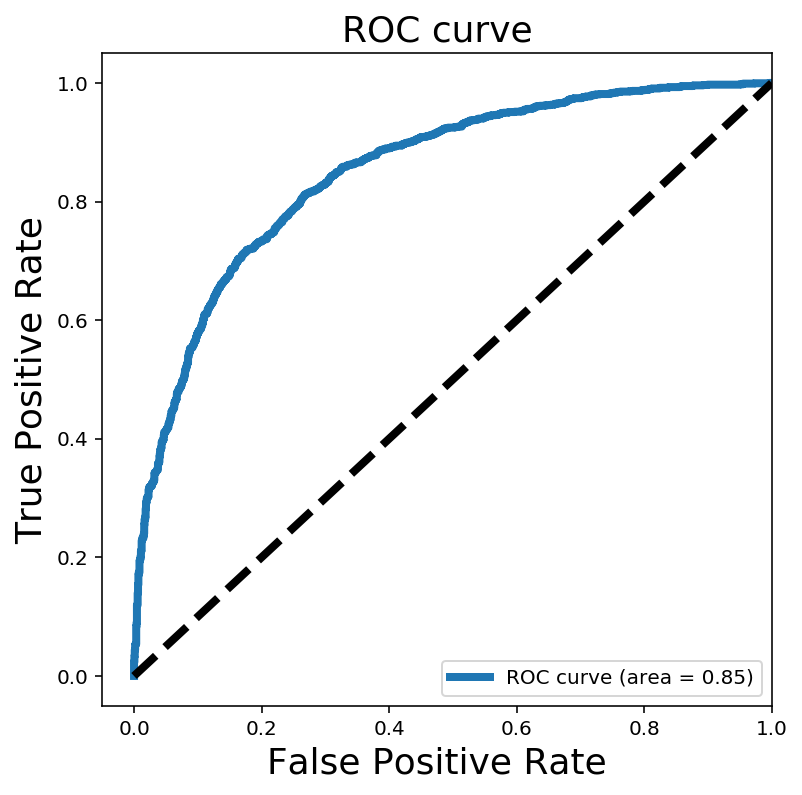

In [282]:
fpr, tpr, threshold = roc_curve(y_test, lr_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=[6, 6])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC curve', fontsize=18)
plt.legend(loc="lower right")
plt.show()

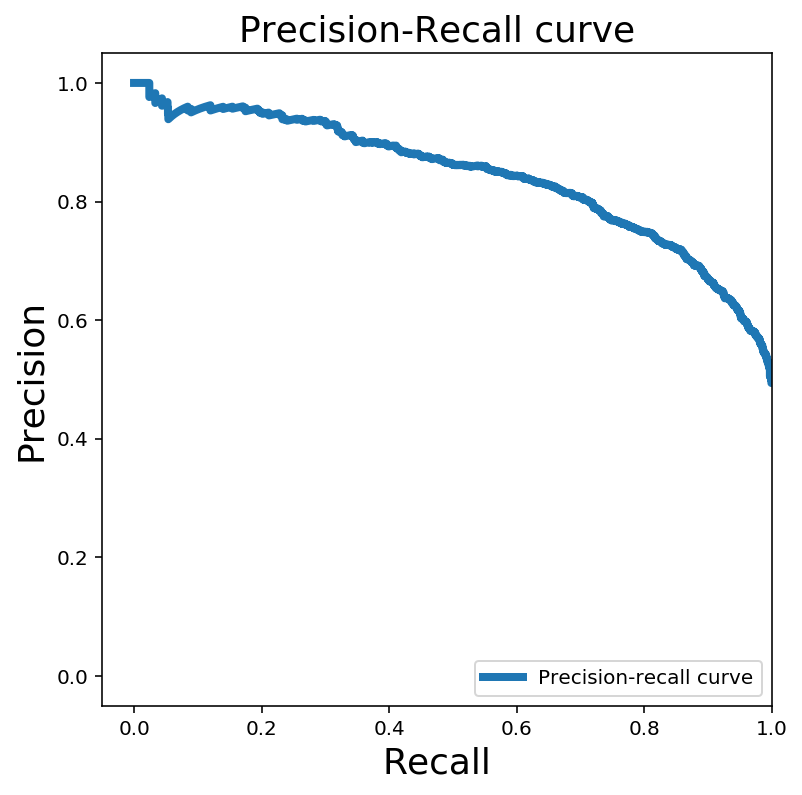

In [93]:
precision, recall, threshold = precision_recall_curve(y_test, lr_prob)

plt.figure(figsize=[6, 6])
plt.plot(recall, precision, label='Precision-recall curve', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall', fontsize=18)
plt.ylabel('Precision', fontsize=18)
plt.title('Precision-Recall curve', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [123]:
#Top coeffifients, not including positive words

log_coeffs = pd.DataFrame(zip(log_pipe.steps[1][1].feature_names, log_pipe.steps[2][1].coef_[0]),
                          columns = ["feature", "coeff"])

log_coeffs["abs_coeff"] = log_coeffs["coeff"].map(lambda x: abs(x))

pos_words = ["great", "excellent", "delicious", "fantastic", "perfect", "wonderful", "beautiful", "amazing", "awesome",
            "love", "tasty", "nicely", "super", "best", "incredible",]

log_coeffs[["feature", "coeff"]][~log_coeffs["feature"].isin(pos_words)].sort_values("coeff", ascending=False).head(10)

,feature,coeff
9869,juicy,3.211357
18473,tropical,2.866407
10935,mango,2.767153
13317,pineapple,2.394124
8164,grapefruit,2.385143
18450,trillium,2.234247
3744,citrus,2.210903
4921,dank,2.191134
8300,growler,2.175195
1738,balanced,2.016358


In [128]:
#Bottom coeffifients, not including negative words

neg_words = ["bad", "decent", "average", "ok", "lacking", "little", "disappointing", "didn"]

log_coeffs[["feature", "coeff"]][~log_coeffs["feature"].isin(neg_words)].sort_values("coeff", ascending=True).head(10)

,feature,coeff
19427,watery,-2.214171
2255,bland,-2.141455
13820,pretty,-2.123430
11277,metallic,-1.972654
8146,grainy,-1.971870
6868,faint,-1.913226
8138,grain,-1.901314
16641,special,-1.896361
10146,lager,-1.841073
5431,dimensional,-1.779304


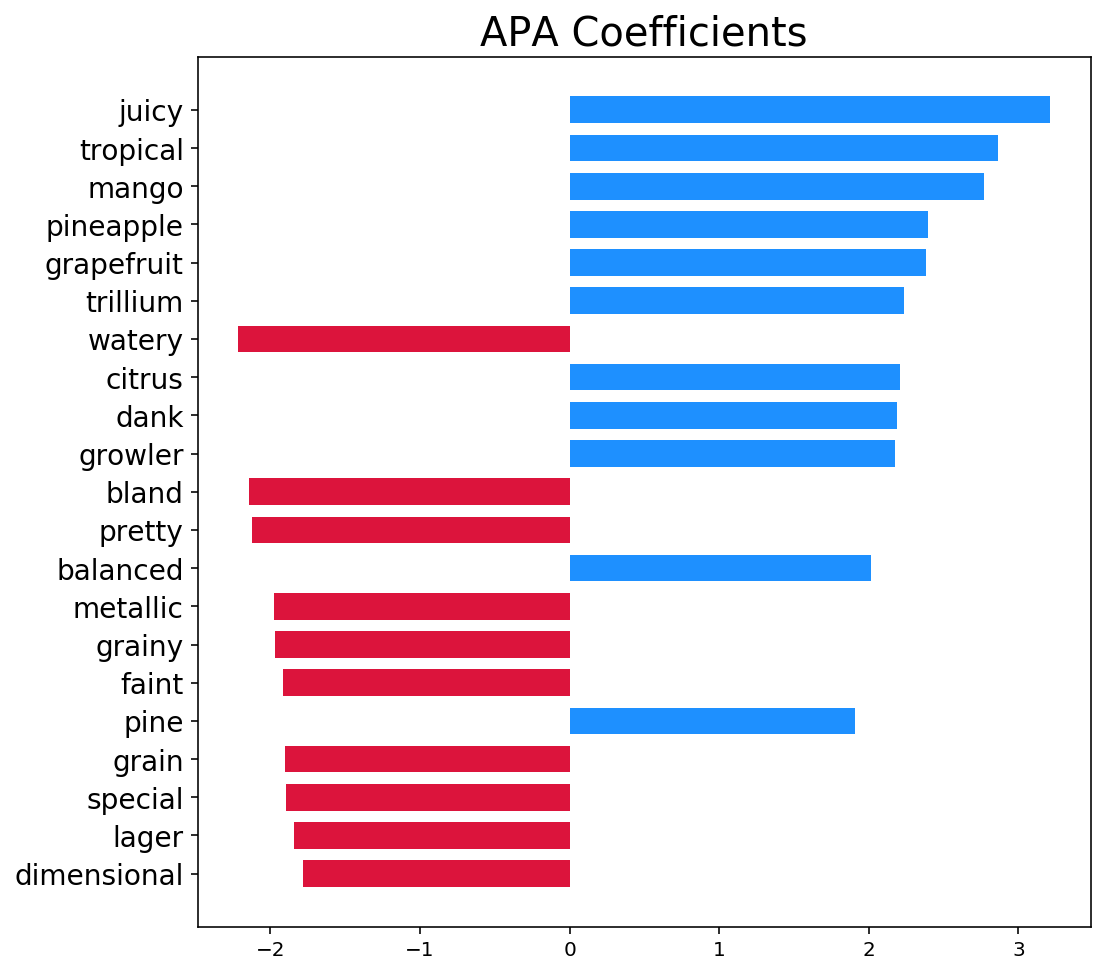

In [228]:
top_coeffs = log_coeffs[~(log_coeffs["feature"].isin(neg_words)) & 
                        ~(log_coeffs["feature"].isin(pos_words))].sort_values("abs_coeff", ascending=False)[:21]

fig = plt.figure(figsize=(8,8))
plt.barh("feature", "coeff", 
         height=.7,
         data=top_coeffs.sort_values("abs_coeff"),
         color=["#1E90FF" if x > 0 else "#DC143C" for x in top_coeffs.sort_values("abs_coeff")["coeff"]])
plt.title("APA Coefficients", fontsize=20)
plt.yticks(fontsize=14)
plt.show()

Notes:

 - Dank refers to a kind of beer (strong, earthy IPAs?)
 - Trillium is a brewery
 - Growlers are large, refillable beer containers (smaller than a polypin - like a large bottle)
 - "Pretty" - spot checking suggests it's usually a qualifier (e.g. "it's pretty good"), but sometimes about looks
 - Dimensional is usually used in the context of "one-dimensional"
 

### Trying out the model on brewers' descriptions

In [18]:
beers = pd.read_csv("../../data/apa_beers.csv")

In [42]:
beers["review"]=beers["desc"]
clean_beers = beers.dropna()

In [45]:
#setting X and y, and creating split
X=clean_beers[["review"]].copy()
y=clean_beers["av_rating"].apply(lambda x: 1 if x > 3.9 else 0)

#Setting up pipeline
new_pipe = Pipeline(steps = [ ("vec", vec),
                              ("model", model)])

#Fitting and scoring model
y_pred = new_pipe.predict(X)

In [48]:
from sklearn.metrics import accuracy_score

accuracy_score(y, y_pred)

0.6194690265486725

In [49]:
1-y.mean()

0.504424778761062

In [53]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.32      0.46        57
           1       0.57      0.93      0.71        56

    accuracy                           0.62       113
   macro avg       0.69      0.62      0.58       113
weighted avg       0.70      0.62      0.58       113



In [54]:
conmat = confusion_matrix(y, y_pred, labels = [1,0])

pd.DataFrame(conmat,
            columns = ["p_high", "p_low"],
            index = ["high", "low"])

,p_high,p_low
high,52,4
low,39,18


In [55]:
clean_beers["rating_pred"] = y_pred

In [67]:
for i in range(0,11):
    print(clean_beers[clean_beers["rating_pred"] == 0].iloc[i,6])
    print(clean_beers[clean_beers["rating_pred"] == 0].iloc[i,10])
    print("")

3.91
Alc. by Vol.: 5.0% IBUs: 40 170 calories per 12 oz serving

4.11
Available: January to May Alc. by Vol.: 6.2% IBUs: 60 192 calories per 12 oz serving

3.92
Crisp and aromatic, this boldly-hopped American ale balances notes of citrus and tea-like earthiness from American hops with a subtle German malt base.

3.64
Fire Rock Pale Ale is crisp, refreshing “Hawaiian-style” pale ale. Its signature copper color results from the unique blend of specialty roasted malts. The pronounced citrus-floral hop aroma comes from the liberal amounts of Galena, Cascade & Mt.Hood hops added to each brew. 35 IBU

4.12
38 IBU

3.71
 to be boastful, but we honestly believe all others pale in comparison to this one. Crisp and hoppy, Philadelphia Pale Ale is brewed with Pilsner malt and American hops, which impart a surprising citrus aroma.

3.78
availability: year-round bitterness: 32 IBU alcohol by volume: 5.7% original gravity: 14.0° PLATO malts: Pale, Caramel 20L, Caravienne 20L, Caramel 80L, Carapils h

In [11]:
len(log_pipe.steps[1][1].feature_names)

20057

In [13]:
X.shape[0]*

17349

In [14]:
X.shape[0]*len(log_pipe.steps[1][1].feature_names)

347968893

### Roc/ PR curves

In [88]:
X=clean_beers[["review"]].copy()
brew_prob = [y for x,y in new_pipe.predict_proba(X)]

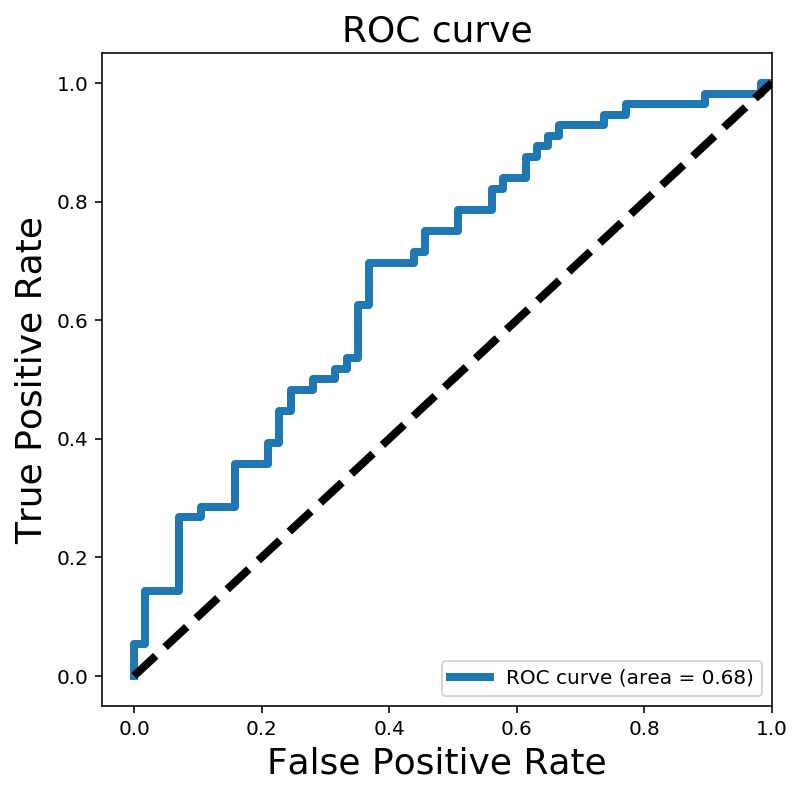

In [89]:
fpr, tpr, threshold = roc_curve(y, brew_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=[6, 6])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC curve', fontsize=18)
plt.legend(loc="lower right")
plt.show()

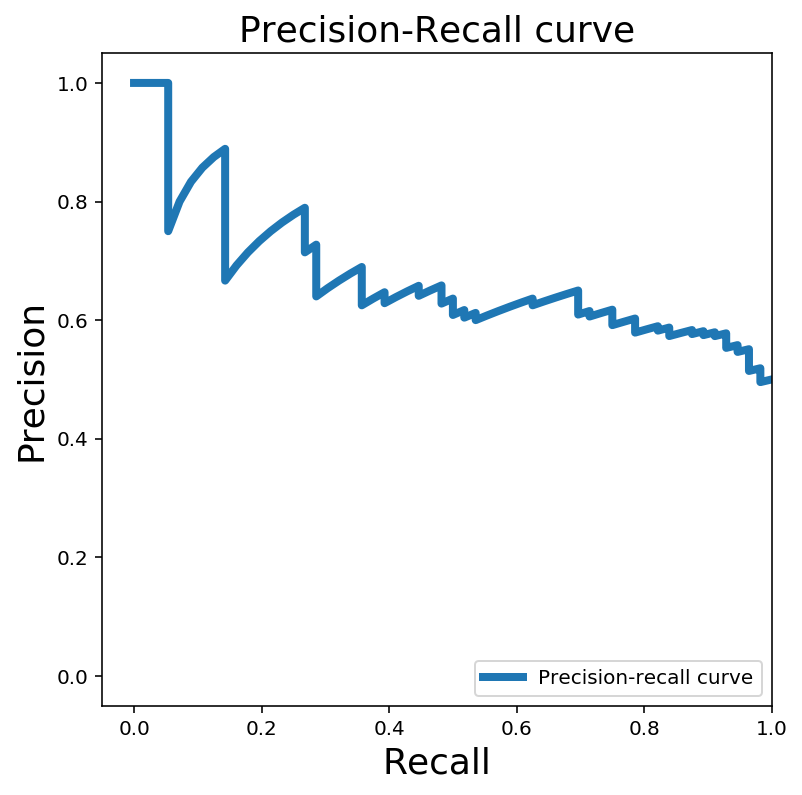

In [86]:
precision, recall, threshold = precision_recall_curve(y, brew_prob)

plt.figure(figsize=[6, 6])
plt.plot(recall, precision, label='Precision-recall curve', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall', fontsize=18)
plt.ylabel('Precision', fontsize=18)
plt.title('Precision-Recall curve', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [118]:
beers[beers["brewer"].str.contains("Trillium")]

,id,name,brewer,style,abv,rank,av_rating,n_reviews,n_ratings,desc
19,88949,Fort Point Pale Ale,Trillium Brewing Company,American Pale Ale (APA),6.6%,99,4.47,245,"2,205",Our signature American pale ale balances light...
27,107406,Galaxy Dry Hopped Fort Point Pale Ale,Trillium Brewing Company,American Pale Ale (APA),6.6%,100,4.57,202,"1,727",This version of our signature American pale al...
30,116067,Double Dry Hopped Fort Point Pale Ale,Trillium Brewing Company,American Pale Ale (APA),6.6%,100,4.59,196,"1,689",This double dry hopped pale ale contains the s...
42,154542,Mosaic Dry Hopped Fort Point,Trillium Brewing Company,American Pale Ale (APA),6.6%,100,4.52,148,"1,257",With this distinctively dank Fort Point varian...
135,200781,Launch Beer,Trillium Brewing Company,American Pale Ale (APA),5.7%,92,4.17,86,436,First brewed to commemorate the grand opening ...


In [229]:
for i in range(0,apa_df["review"].str.contains("special").sum()):
    print(apa_df[apa_df["review"].str.contains("special")].iloc[i,0])
    print(apa_df[apa_df["review"].str.contains("special")].iloc[i,6])
    print("")

4.92
The Sierra Nevada Pale Ale is the BEST “standard ale” for taste, appearance and feel. It’s hard to believe it’s a “daily beer” for the amazing quality of taste and aroma and texture. No beer can touch this one for a daily drink ale. The Sierra Nevada hoppier ales (like the Little Hazy Thing and Celebration Ale) kick it up a notch with more highlights, but are truly a more “special brew” style not a daily brew to enjoy. My personal favorite for an ALWAYS tasty brew year round!

2.97
Straw yellow at pour, looks redder and more opaque in the glass. A thick head of suds. Mildly scented...corn? Taste is slightly bitter, yet mild for a pale ale. Not especially floral or citrus-like. Mouth feel a little thin.

4.28
Sierra Nevada's flagship product, Pale Ale, is that one beer for me that delivers every single time. It embodies almost everything I look for, and especially what I expect, from a beer: freshness, character, lasting enjoyment from first to last sip, and the ability to stand up

Pours a hazy, amber color topped by an inch of coarse, white suds. Wonderfully tropical aroma evokes lemon, mango, and grapefruit. Bountiful lees can be seen both in suspension and on the floor of the glass. The taste is founded on a deft balance of lemongrass, lemon, pepper, and biscuity, crackery malt. The synergy between malt and hops, both of which are tastefully understated, is quite excellent--a cohesive whole more so than the sum of its parts. Medium body and delicate carbonation produce a smooth, velvety mouthfeel that's reinforced by a mildly chalky yeast character. A dry finish leaves you ready to dive back in for more. Overall, this is a fantastically well-balanced and refreshing APA. While not especially complex, it is well integrated and has no off flavors to speak of. With its delicate, refreshing flavor profile, herbal bitterness, and luscious mouthfeel, it almost evokes an American interpretation of a saison. This could very well be the best APA I've had.

4.33
Poured f

1 pint, 0.9oz bottle dated 12/01/15 poured into a tulip on 1/21/16. Bottle recommends consumption within 90 days of date printed. Look: Pours semi-translucent honey color with quarter-finger of bright white head. Significant and immediate lacing upon its resolution. Very gentle agitation brings forth significant and very fluffy head that retains well. Tons and tons of lacing. Smell: Sweet, almost cloyingly so. Reminds me a little bit of apple cider or apple juice. Fairly malty. Faint hint of pine and resin. Other fruit notes for sure; citrus and stone fruits. Very interesting, each whiff was a bit different, especially as it warmed. Taste: Malts predominate upfront. Biscuity and fairly sweet. Bit of grapefruit and citrus. Pine and resin with lemon linger afterwards. Feel: Quite carbonated, medium mouthfeel. Wonderful finish. Incredibly satisfying and refreshing. Crisp but not dry. I'm having a hard time describing it. Overall: An incredibly balanced and satisfying experience. Better th

Upfront disclosure: this has been my favorite brewery for about a dozen years. I flatter myself that that award is worth something. But, even if that award is not worth much... this ale is. For those who are tired of paying money to have their buds assaulted by too many hops by too many brewers who are still learning to blend malts, then this is the beer for you. 6/12/16 re-rate: Decreased Smell by .25 and increased Taste as Moon Man went well with guacamole. Bumped-up the Overall .25 because I really do like the progressive Heartland mindset of this beer: nothing extreme, just be. 8/15/17 Moon Man clearly has become a regular of mine as long as I live in Chicago and can jump the border. Had Moon Man this time as 1/2 session and 1/2 to accompany Indian leftovers. I enjoyed my Moon Man lunch very much ! 8/18/18 It is summer and it is time for Moon Man. Because it is malted well and its hops are subtle, it pairs well with most summer foods, especially if they get grilled. 8/19/19 Getting

First real go at a FFF brew... on tap at our (somewhat) local pourhouse, Vintage Estate. This was bright, crisp, and refreshing. Poured a nice amber hue with some long-lasting white head. Some fruity and floral hops on the nose, and crisp bitterness and just enough sweet malty goodness to balance it all out. Nice choice for a lower ABV pale, especially good when looking after 3 kids on the ride home! Can't wait to try more FFF!

3.93
12 oz. Pours a hazy orange-gold, over an inch of fluffy white head dissipates slowly to fine suds, never fully goes away. Smells of fresh grapefruit hops and semi-sweet grassy malts, hint of honey. Grapefruit citrus and hops with grassy malts and a mild bitter hop bite. Some honey and lemon in there.  Medium to full body with soft tingles of carbonation on the tongue. A really nice well-balanced session candidate, goes down super-smooth and easy. Very easy to like. That said, it's nothing special, just very good at being what it is which is just an easy-dr

A: Excellent light yellow/orange color, little haze, finger of head that quickly dissipated after a minute.  S: Floral, citrus, bready, the usual suspects. Nothing too special, or at least I can't taste the specialness T: Follows the nose, pleasing.  M: Light/medium body. Perfect carb. O: It was nice, but nothing outstanding. Drink it again but I won't seek it out.

3.92
Just bottled. Pours a lightly honey golden blonde with a pillowy head of 2 fingers. Lace is just phenomenal.  Fantastic aroma of pine and citrus, just tons of fresh orange, grapefruit, and a little bit o' mango.  Flavor is pretty resiny and piney, contrary to the nose. It is very clean though. Suggestions of honey. There's a good quantity of grapefruit here, but it's sadly overshadowed by resins and pine.  Feel is crisp and clean, leaves a slightly oily residue on the tongue and mouth.  Overall, I'd place this somewhere between Alpha King and Zombie Dust. It's decent, especially the nose, but the fruit is lost in a haz

L - typical Trillium. Warm, glowing off-orange. Opaque enough without letting light through, but not turbid. Inviting.  S - total Galaxy up front. Bready wheaty crackers. Rounds out with some slightly sour bitter (dry?) hops. Orange juice. Pineapple.  T - sweet candied orange juice with a huge sticky breadiness that almost expands outward as you sip. Creates a layer of Galaxy goodness that sort of hovers above the rest of the beer. The dry hopping creates a flavor effect like Saturn's rings, whatever that means. Pineapple of course and a surprisingly mild bitterness. Galaxy hop blanket soothes and comforts. Nice, balanced flavor.  F - soft and flowing as usual. Works especially well with this dry hop.  O - a very tame Fort Point. Mellow, but elegant and well-done. Class in a glass!

4.03
Poured from a single serve into a tulip Pours nearly clear--just a bit of haze--medium gold with a nice two-fingered foamy head. Fairly good lacing throughout.  Citrus aromas very forward--lemon, red g

Original review from 2015: Appearance: Cloudy golden amber, with a big head of off-white suds. Nice loopy tree-line lace. Aroma: Citrus hops. Very nice! Taste: Bright and rich on the hops front, with a heavy body, especially for a “session pale ale”. This is a strong and flavorful pale ale, nearly approaching IPA status. Not bad. New review from 2018, canned Citra-Hopped Live: Appearance: Clean amber with a heavy head of bone-white suds. Attractive web of lace. Aroma: Citrus shops, yes. Floral, fruity, and good. Taste: Bright, fruity and citrusy with a slight bitter finish. An absolute solid beer, no question.

4.01
aside from the fact that the bartender cant put a head on this beer to save her life, i really like this one. its golden and a little hazy, but still light enough looking in the glass. what makes it special is its hop profile. definitely new zealand varietals in here, high alpha and high oil, fruity and tropical and almost smells like a lotion some young hottie should wear,

12 oz bottle poured into a tulip Best by 12-24-13 A- Pours a relatively clear amber orange color. A modest off white head. S- Light and hoppy as the name implies. A nice pine, a sharp resinous bit. A complex fruitness and a light malt honey sweetness to make it pop.  T- A perfectly balanced and moderate bittersweetness at first. A really nice mix between the honey like malt and the hop bitterness.The first flavor I get is a honey flavor, then the hop profile starts to come in. A herbal flavor at first, followed by a refreshing pine, then pine sap, then a light fruityness. A bit of lemongrass, a touch of grapefruit. A well rounded and tasty beer. M- I could drink this all day. It has a complex flavor profile that keeps it interesting and a mouthfeel that wont burn your palate. O- An awesome fresh hop ale. Arguably one of the best of the style. I'm lucky to have been able to land some as Deschutes is yet to arrive in KY. Definetely worthy of getting, especially for the price tag.

4.32
B

I enjoyed this on tap at Federal Taphouse in Harrisburg, served chilled in a pint.  The color is a cloudy golden with thin white head with fine bead and ringlets of lace stick.The smell is great with lots of floral hop aromas with mild citrus zest and slight tropical fruit in the nose. The feel is decent with tangy semi-dry and pretty bitter texture with low sweetness and semi-dry finish with moderately high carbonation and moderately bitter finish.  The taste iis tangy with lemony hop element and subtle acicidty in the taste with mild citrus golden grapefruit-like punch with somewhat herbal hop quality and grassy aspect with a light astringency level and dry finish. Overall this is better than most beers of this style but I would not want to drink more than 1 in a sitting a bit too assertive bitterness wise for the abv -pushed to the extreme in a way I am not fond of especially.

4.75
Appearance: very light yellow. Lightest APA I've seen
Smell: pleasant citrusy hops
Taste:,this is an 

I had this on tap at the Goose Island Bar at O'Hare. It was refreshing and nice compared to my choices at the other establishments. As far as american pale ales, I felt this was a little lacking and considering its a specialty release for the Chicago area I expected something a little more premium. I was hoping for a little more pronounced hop flavor. It had a nice biscuity malt profile of a blonde ale.

3.18
Poured on tap in a 6oz tumbler at a Beer Garden we found in Chicago. Review is from my notes. Pours a slightly hazy blond pale color complete with carbonation at the top that resembles soapy suds of sorts. Carbonation rises modestly in this, but it's nothing too large or cascading. Lots of lacing sticks to the glass here, and combined with the color, this looks a lot more like an American wheat ale of sorts than a standard APA. At the aroma, I'm getting actual wheat, lime, coriander, and lots of golden grains, combined with a soapy, slightly bittered finish. Sure there's no wheat 

I keep coming back to this ale over and over. Besides the fact that Lagunitas price point is ridiculously affordable, this ale easily surpasses other ales that are priced three or four times as much. After drinking a Stone 19th Anniversary Thunderstruck IPA (Also a great ale, don't get me wrong), this ale hit the spot again. I have probably enjoyed at least a dozen of these 22 oz. Equinox ales, and this was perhaps the best. In this instance the malt stood out as the star, whereas we normally play a game of name that tropical fruit. maybe the straight forward IPA that I had prior to this blew that aspect, but oh well. The malts taste amazing, and the papaya flavor is still there for me. Once again, Lagunitas shines on their special releases! At about $4 / 22 oz, you just can't beat the flavor here. As a former Stone addict at $7 a piece, I prefer Lagunitas 99% of the time. Equinox is rad!!!

4.1
a: Translucent amber with an inch plus thick white head which receded to thick surface foam

When I embarked on The CANQuest (tm) over a decade ago, Oskar Blues' Dale's Pale Ale was the only micro in a CAN &amp; in a 12-fl. oz. CAN at that. Since then, we have seen Pounder CANs, SlimLine CANs (think Red Bull), Crowlers &amp; now the latest, Stovepipe CANs (19.2-fl. oz.). Today's side-by-side with CANsist of a 12-fl. oz. CAN, followed by a Stovepipe CAN. How exciting! No? Just to me? Oh, well.  From the 12oz mini-keg CAN: "... I asked her 'Where do we go from here? Who IS my partner in crime?' and then it struck me, like an arrow, right between the eyes ..."; "As the River Styx froze and the final pig took flight, when the last winged monkey departed the darkly fragrant Netherlands, as wishes became horses and all the beggars rode ..."; "... under a newly-blued moon at dawn on the very 12th of Never: the second-to-last craft brewery in America pressed the green 'start' button on their canning line. We wanted to be the Last Small Brewer in the U.S. to can their beer and maybe, f

Purchased a 2L of this in person from the Brewery on Saturday. Shipped back to Birmingham chilled and opened. Poured into a Piggly Wiggly snifter.  A: this beer is by no means clear, it cloudy and hazy. Yellow to golden in color with the best looking head I've ever seen on a beer. Lacing is thick and sticks to the glass in heavy sheets. This beer is beautiful to look at.  S: what an amazing aroma, pure Citra. Pineapple, Grapefruit, Dragonfruit heavy in the nose. Reminds me of the last time I drank Zombie Dust. They should make an air freshner that smells like this.  T: citrus hops bitterness with a very soft roundness to the beer. It's not harsh like most heavily hopped IPA's or Pale Ales. It's easy as hell to drink with the lower abv. Beer finishes dry and has a very light malt back bone. Tons of pineapple in the flavor.  M: the softness of the beer beings out the oils in the hops, it's oily but very easy drinking. No alcohol is noticed. I could drink the entire 2l in one sitting, if 

A - Cloudy with yeast. This brew is a vibrant tangerine color with a smallish head of eggshell-hued foam. Good lace. S - Lemon juice, white pepper, and sea salt. Odd... especially for the style. Lemongrass. T - Astringent grassy hops really assert themselves. Freshly mowed lawns, bitter arugula-type greens.  M - Medium bodied, sharp and astringent.  Odd as heck, but not at all bad. This would cut right through a spicy dish. Given the fact that this stuff is ubiquitous in my neck of the woods (90 miles from St. Louis) this could be a go-to beer for Thai or Indian nights.

3.5
It is a cold, snowy day - perfect for catching up on some reviews from my notes. I always like to try local or special beers when out for dinner (my friends can have Budweiser in St. Louis, I will take Schlafly). Golden orange pint, short and quickly disappearing white head.  Hops are noticeable in the first whiff, some malt sweetness as well. Flavor has a good malt base, with lots of hoppy flavor. Fruity and citru

(3.65) O: Overall very good level of hopping, creamy maltiness, nice drinkability leaving with a lingering grassy fade

3.39
$8.60 plus deposit for a 6o0 ml bottle at the 8th Street Liquor Store at New West station. Pours a hazy gold with two fingers of head that doesn't stick around for long. Looking at this one, it could be a hefeweizen. Aroma is quite mild. Not much going on. Taste is fairly bitter. There's not a whole lot of orange flavour, unless by orange flavour one means citrus rind. There's plenty of that. Mouthfeel is okay. Not bad, but nothing special.

2.98
Based on the relative oddness of this entry (especially when compared to my local Prism's rather refreshing Blood Orange beer) this is the first brew I've been moved to review in a while... 12 bottle into a standard pint, as I feel an APA should be served. Appearance: This is one of the more murky Pale Ales I've ever seen and it says nothing about being unfiltered. It does keep an okay white head though and it's color is

12 fl oz brown glass bottle with appealing label art and branded pry-off pressure cap acquired at Zipp's Liquor in Minneapolis, MN for $1.79 and served into a stem-tulip. Reviewed live. Expectations are high given the brewery. 5.2% ABV confirmed. Packaged 07/29/13. Reviewed as a pale ale because of the name, though the label description calls it a blond ale.  Served cold - straight from the fridge - and allowed to warm over the course of consumption. Side-poured with standard vigor as no carbonation issues are anticipated. A: No bubble show forms as it's poured. Pours a one finger wide head of white colour. Disappointingly thin. Lacks creaminess and frothiness. Consistency is smooth. Complexion is decent; not particularly soft or supple. Head retention is average - about 2 minutes. Little lacing clings to the sides of the glass as the head recedes.  Body colour is a hazy nontransparent translucent mango colour. Sort of a reddish orange - kind of hard to pin down. Average vibrance. No f

A:Pours piss yellow. There's no helping that. Has a bit of a head, but it quickly dissipates. It's a pretty looking beer, I suppose, though a bit darker than its lager cousins. S:Not a strong odor to it. Has a bit of a sharp fruity presence not there in the lager. More on that later. T:Good taste. Hops presence is immediately distinguishable along with some fruit undertones. A bit of sweetness on the tongue as well as a fair amount of bite. M:Not as oily as the lager. Not as pleasing as Bass. Sparkles on the tongue. Decent and average. Decent beer. Saw some of the reviews blasting it. Figured I would give it a try. It's not nearly as bad as some of the other beers I've tried in my life. And this is based on my experience with it in can form. Does it fare well against Dogfish? Of course not, you idiot. Is it a perfectly decent beer for a warm summer's evening? Yes. Is it cheap? Yes. I like it fine, especially for the price.

4.3
I got the 24-pack suitcase cans for a shade under $20 at O

Poured from a can into a tulip, because, why not? A: Awesome hazy dark orange. Half a finger of an off-white head. S: Soft fruit notes, but very little hops or even citrus. Really light scent. T: Whoa. Wheaty and grassy, little bit of honey on it too. Not what I was expecting, but...hm. I kind of like it. Given its name, I want there to be a smack of ham to it (Arrested Development, anyone), but really I just get the grass and honey. I imagine it pairing well with pork dishes. M: Good tingle on the tongue. Not much hop bitterness though. It's cool and refreshing though, especially today when it's 115 degrees in Indy. O: I'm glad I got this as an extra. Thoroughly enjoy it.

3.47
Pours a clear deep gold bordering on pale amber producing 1 finger of beige, somewhat lasting, foamy head that leaves a wash &amp; surface ring of lacing. Aroma is a mixture of caramel, apple &amp; vegetable notes with subdued floral hop hints. Taste is thin semisweet caramel malt, apple &amp; faint honey with 

This is a nice hazy copper color Smell: Lot of tropic fruits, malts are dominant, some sweetness. Taste: Very similar to Sue. This beer tastes like Fruity Pebbles. Nice Tropical flavors, mango, papaya, and other tropical fruits. These beers all have a wonderful creamy mouthfeel. That is what makes them standout! They are so well balanced you could get in a ton of trouble with these! Overall: This is a top notch beer. I just hope I can get my hands on more in the future. The only downside I can say about these beers is that they do not have a bottling date and they do not have the abv. Clearly stated. Which is important, especially for those of us who are trading! Otherwise it’s a damn near perfect beer!

3.86
Picked up a bomber of the newly named Light Speed as soon as it hit Madison. Since we are fortunate enough to get Toppling Goliath here on a pretty regular basis, I was able to have Light Speed along side PseudoSue which to me, is the gold standard of pale ales. Light Speed smelle

12oz can from 7/30/13. Thanks, James! A: Hazy pale amber body under an inch of frothy white head that demonstrates adequate retention and leaves decent lace. Pretty good, but nothing special. S: Uninspiring blend of crackery malt and herbal, piney hops. A little bit of apricot, a little bit of caramel. Some chalk and citrus. Not bad, but not good. T: More straightforward the than the nose, but not too much better. Bready, lightly caramelized malt and hops that walk the line between pine and citrus. The finish is more bitter than sweet, with some minerality along with herbal hop notes. Gets better as it warms, but never becomes terribly interesting.  M: Fairly light-bodied with ample, soft carbonation. Excellent. O: Not a bad little APA, but there's just something about the malt character that rubs me the wrong way. It's not too sweet, exactly, but somehow too sticky. Hard to put my finger on it. Cheers!

3.68
great beer. drank it out of the can. tastes very hoppy and clean. fresh. this

I picked up a six of Sierra Nevada's Sidecar Orange Pale Ale at Meijers Last week. I bought a six pack a month ago and it ended up being recalled, so now that a new batch showed up I thought it would I would give it another try, so lets see how it goes. 2017 Vintage. Poured from a brown 12oz bottle into a imperial pint glass.  A- The label looks nice, it goes well with the name and it's a little eye catching. It poured a darker orange color which took on more of a golden orange color when held to the light and ti had two fingers worth of fluffy off white head that died down to a thin ring that eventually faded away and it left some spotty lacing behind. This is a pretty nice looking beer, I have no complaints.  S- The aroma starts off with a slightly higher amount of medium sweetness with the orange being the first to show and it impart a big citrus and orange aroma that's a little juicy and it's the aroma that shows up the most in this beer. Up next come a slight bit of doughy yeast t

Poured into an E&amp;J Cask &amp; Cream glass on 9//26/11 Bottled on 6/28/11 Hazy, burnt tangerine color with pale, golden hues at the stem. The head starts off just shy of a finger's worth and thins from there. Thin layer of retention with a clumpy ring and good lace. Tart lemon juice notes are interjected into aromas of orange pith and grass. The lemon aspect is definitely grabbing. Biscuit malts and a hint of toasty bread linger underneath.  The flavors are comparably bright, though the citrus notes are not at the fore. Instead, there is a lofty grassy presence and some floral notions. Tangy citric tones move in from the edges. Toasted bread rounds it out. Maybe a scratch or two of pine in there. It definitely has a nice hop kick to it. The feel is somewhere between light to medium body, probably leaning more toward the former. Carbonation is ample but never seems to over shoot the feel of the beer. Very dry, especially on the finish. Prickly resin with a delicate dusting of grainin

A: Dark orange, khaki head is creamy but flimsy and quick to dissipate. Good strong sense of carbonation and visible floaties. Lacing is modest.  S: Aroma of pine and caramel, grapefruit grind, with some underlying notes of leafy herbaceoucs scents. Grapey, viney notes with an all told fair and average offering for a pale.  T: Scotchy grapefruit and pine with some dry speciality grains. Decent level of dry hoppiness, though flavor spectrum is limited. Lemony-buttery caramel fade.  M: Good deal of malt depth, creamy, medium-full body, dry.  O: Overall not bad, slightly above average offering, dry, sweet with an alkaline finish. Decent with a high C rating feels about right. wouldnt go out of my way for.

4.0
Poured from 12oz can into a pint glass. Appearance: hazy golden hue with plenty of floaties and a mild effervescence. Head pours two thick fingers of frothy ivory foam. Quite decent, actually. Smell: sweet malt and a rich, funky hop arome with citrus, earthiness and just the right a

22 oz bomber obtained in a BIF from Cuzco, gracias! Has a best by stamp of 06/10/10. Pours a light gold color with a slight amount of haze. Foam is creamy, frothy and long lasting. Leaves some nice lacing as well, pretty good looking beer. Nose is pretty faint, but what is there is pretty nice. Fresh, mildly minty hops with a hint of lemongrass. Malts are pretty neutral and only contributes a touch of graininess. Steel Rail EPA has a very fresh taste with a nice dose of both flavoring and bittering hops. A bit of both the mint leaves and lemon peel noticed on the nose come through in the tasting as well. Malts stay in the background for the most part but do contribute a biscuit and light toasty aspect. Not much of a wow factor for this one, but would make an ok summer sessioner. Mouthfeel is a bit on the thin side, but that is to be expected with a grain bill this light, I would not be surprised if zero specialty malts were used. Not bad, I enjoyed trying it...but of the two Berkshire 

Served on-tap at Frisco Grille in Columbia, MD into a shaker pint glass at the appropriate temperature (01/09/10). A: Pours a clear light golden amber with one finger of an off-white head that settled to collar leaving some patchy lacing. S: Faint aroma of grassy and bitter hops along with a sweet malt.  T: Some grassy and bitter hops combined with a semi-sweet caramel malt. The bitterness lingers after the finish. Decent, but nothing special.  M: Light to medium-bodied with moderate carbonation and no hint at all of the modest 5% abv. D: Quite drinkable and rather sessionable if you can get over the fact that this is certainly not the most flavorful American Pale Ale. Overall this was a decent easy drinking American Pale Ale from Stoudts, but there are many more examples out there that I would rather drink. Worth a Look.

3.63
12oz bottle courtesy of thecarster1 poured into a pint glass. Pours a fairly clear, light golden orange with a thick white head that leaves good lacing and a sm


2.62
An interesting take on a pale ale but unfortunately it's a one and done for me.  Appearance: Hefeweizen like appearance. Very hazy with floaters at bottom. Lacking head size and retention. Very faint off-white lace. Smell: Intense citrus and somewhat sweet smelling. Apple, pineapple (ethyl hex?), or maybe it's a bit oxidized. Slight perfume. Different, but not really that appealing.  Taste: Bursting with sweet citrus flavor. Pineapple again. Sweet and lacking bitterness, especially in the finish.  Mouthfeel appropriate for style.  Drinkability:  Too sweet to be enjoyed again.

3.41
A- Hazy straw yellow with a foamy white head that has decent retention. A good amount of fine lace. S- Light caramel malt with some light fruit notes. Some yeast hints. Not much going on here at all. T- Starts out with light fruit, caramel malt. Finishes with a mix of pine/floral hops, light fruit, and biscuit/bready malt. Slight Belgian yeast and spice throughout along with some nutty hints. MF- Light

12 ounce can, with a paper sticker on the bottom, telling me this is best by 4/01/13. Pours typical amber, dull and murky, lite tan head, goes rapidly to a medium buble film, collar and thicker bands of lace. Dull bready nose, with just a hint of hops. Middle of the road APA. Hops muted, malts in control. Notes of caramel, honey, and then just some dusty hops in the finish. More of an English pale in style and attitude. Nothing special going on here. Glad to give it a try, but I'm happy to have purchased just a single can.

3.44
Clear gold under a beautifully thick, mousse-like head. The aroma is quite floral and soft...very dry, grassy, and a little toasty. Tasty, balanced flavor. Cascade hops, floral notes, mild pine, apricot, and sweet, biscuity malts. Nothing really special, but perfectly enjoyable overall. Medium bodied and drying. Pretty good.

4.08
brought back 6 of these from the land down south thanks to a dear friend. brilliant clear fiery red with a pungent and promiscuous j

16 ounce can into an oversized tulip. 3/17/2016 can.  Surprisingly lacking in foam on the pour. Very little head forms over the golden body with a copper hue. Carbonation is clearly visible and rises incessantly, feeding a slight film over the body. 3.75 Pretty light on aroma, but I do get some faint grapefruit, unripe mango and some hints of OJ. Also hints at light resin and biscuity malt. I like what I'm smelling but struggle to get much of it. 3.5 The flavor appeals more to me than the aroma, with a more pronounced (compared to the nose) grapefruit flavor and zest and a pleasant biscuit-with-honey malt taste. Very lightly, sweet tangerine peeks in. The finish is a touch floral. All throughout the flavors are gentle and approaching timid, but still enjoyable. 3.5 Light-bodied to the point of almost being watery, the zesty citrus bite and floral bitter finish help give this a beer feel. Sweetness is there in a fleeting way that doesn't distract from the zest or bitterness, although es

Growing up a huge fan of many Sub-pop artists (Love Battery anyone?), I'm kind of excited to pop this one open... A - Two fingers worthy of exceedingly creamy light tan colored head that is slightly rocky and includes some big chunky bubbles... An pale light caramel color... Loaded with swirling carbonation that moves at a pretty good clip... Some foam clings to the glass... S - Not much of an aroma at all... Some pale malts... Some Caramel... A super faint whiff of muted citrus... Perhaps a slight hint of nuttiness... T - Toasted malts... Pale malts... Caramel... Nuttiness... Seltzer... A surprisingly sharp but shallow bitterness rises on the finish... The finish is laced with a slight metallic presence...  M - Medium bodied... A tad of lively carbonation... Slightly sleek... Dry finish... Rather pedestrian...  D - Easy drinking and quite sessionable... Nothing fancy and nothing off putting... A rather average brew tied to one of great independent record labels off all time... Nothing

12oz. bottle poured into a 20oz. wiezen. There is 3" of pure white foam that lasted several minutes, now it has settled to a thick covering with lacing left up the glass. The color leans toward a hazy orange, with lots of fine carbonation. The aroma is a sweet citrus smell, not strong but more than light. I like it. The taste is good, citrus , a bit bready, crisp, dry. Very drinkable. The feel is medium, almost creamy. I think the little bitter dryness hides some of the feel. This beer is good, not offensive at all, but truly not special. I would never say no to a Poleeko Pale Ale!

4.44
This is a great session beer! It pours with a nice golden yellow color with a half inch white lacy head. It retains the head for the next 20 minutes or half hour, however long it takes you to enjoy this little guy. The aroma is bright and spicy with a little touch of Evergreen forest. Initial taste is exceptionally clean and bright. The hops come forward quickly. But the balance Created by the malts pr

A - This ale pours a dark pumpkin orange with a thin white head that laces quickly but the rim has some serious retention. Scant amounts of carbonation available.  S - sharply hoppy without hop-bombiness, poignant but not strong, a malty backbone provides support but doesn't particularly add to the aroma  T - The hops pick up in the taste, at least initially. The first tongue splash makes you think this beer is going the (D)IPA route, but just for a split second. The hops plateau and the malt creeps up and balances ideally.  M&amp;D&amp;O - quite drinkable, the elements bland nicely, especially as it warms a bit. Blithely complex, with no pretension. A well crafted beer. Shorts...PLEASE COME TO NEW ENGLAND PERMANENTLY!!!

3.18
Pours an attractive golden amber in the glass. Average head and lacing. Hops in the nose but not especially fragrant. Some of the browned biscuit taste. A touch of darker malt with a fain winey flavor. The carbonation and mouthfeel are well, beery. Slightly sharp

Poured from 12oz bottle into a pint glass. A: Beer is a transparent deep bronze color with slighty off-white head. Head is a fairly stable, but thin layer, leaving some lacing. S: A touch of citrusy American hops. Definitely could have been more here. T: Aggressive hop bitterness up front. Malt flavors that follow are slightly sour. Clean yeast profile. Saaz hops make an appearance at the end, especially in the aftertaste, but feel out of place to me. M: Carbonation feels right. The beer isn't too sticky or too slick. D: The bitterness on this beer was more than I expected and feels a little unbalanced. Not the kind of thing I would want to drink more than a few of.

2.73
This is the classic middle child. I am a middle child and this pale matches me perfectly. Nothing special about it. Nothing offensive, but also nothing distinctive about it in any way. The hop character is average, the maltiness compliments the hops in an average way. The standouts in this style leave little room for 

Had this on-tap at Meridian in Berkeley. Poured with a cascading head from the nitro tap that settles to a medium cap of about 1/2 inch and leaves some slight lacing. Smells a bit nutty and bready to start, followed by citrus, and especially pine, from the hops becoming prominent. Strange how differently this tastes on nitro with those nutty and creamy notes before t6he pine and citrus bitterness kick in. Very smooth in the mouth, this was pleasant, even though its hard for me to take nitro taps all that seriously.

4.0
Sun-splashed Sunkist orange with a generous amount of vigorous carbonation. The result is a large cap of less-than-sticky foam the color of old newspaper. The head is persistent, however, and the glass ends up with a few blips of sudsy lace. The nose is pure West Coast APA/IPA. Plenty of juicy grapefruit makes guessing the hop bill a no-brainer. Centennial (and maybe one of the other C-hops) is almost certainly in use. The only thing that's Imperial about this 5.2% ale 

Pours a clear copper color with hues of amber. Lacing is okay. The head amounted to a solid inch. Pine and floral hops. Not especially hoppy. Malts are entrenched in semi-dry caramel. Okay. Spiny pine and floral hop bitterness, compiled by drier flavors despite a sweeter caramel malt base. Malt punch like biscuits and some vegetal notes. Has a hint of stone fruits. Almost faintly tart. Sips okay, mostly because it's thin. Carbonation is low, too. Generic feel for a harvest IPA. Okay. Nothing to look forward to, with all due respect.

4.2
12 oz. bottle, no bottled on date present. I didn't know this beer was limited / brewed once so I had to pick up another bottle and see what the deal is! Uncapped and poured to a Boulevard tulip. A - Not as coppery as I would have imagined, based on other people's reviews. More towards an orange-reddish IPA look with a hint of copper haze. Hazy cloudy orange with about one finger of head, going down quick. Significant lacing. S - Lemons. Pine hops. Sme

From 03/09/13 notes. Had on tap at BIggie's in Hoboken, NY. 16 oz. pint glass. a - Pours a somehwhat clear golden-orange color with two inches of bright white head and moderate carbonation evident. s - Smells of pale malts, light lemon, and citrus hops, and some bready malts. Not bad but pretty bland nose; not much too it. t - Tastes of citrus hops, lemon, fruity malts, floral hops, bready malts, pale and toasted malts. A little more citrus and more going on than the nose; a slight step up. m - Light to medium body and moderate carbonation. Pretty easy to drink beer. o - Overall a pretty average APA. Nose doesn't have much going on, though the taste is a little bit better. An easy to drink lighter pale ale; better alternative than the BMC beers but nothing very special.

3.53
Appearance: Poured into my new Leinenkugel's beer mug. Amber color, not much residual head. Smell: Smells a lot more malty than hoppy. Seeing as how I'm a hop hog, this is disappointing. Taste: Malty flavor, not m

This brew was served on tap at Toppling Goliath Brewing Company in Decorah, Iowa. It arrived in a tasting stange, showing a ruddy copper coloring. It held a creamy one finger head of soapy white bubbles, showing nice retention. Lacing sat in hollow, mountainous peaks around our glasses. No haze or sediment was noted, and carbonation appeared to be lightly active. The aroma was clean and light, giving off bursts of grapefruity citric and floral hoppiness, crispy and toasty pale and soft amber grain, thin plastics phenols, sweet ethanol, corny adjuncts, nectary fruitiness of apricot and lime flesh, powdery ale yeastiness, white flour, and glassy metallics. The flavoring was much more robust and full, and was composed of sweetly citric grapefruity, grassy, and floral hops, rubber, sea salted seaweed, mildly toasted pale and crystal grain, bittering lemon and lime zest, honeysuckle, corkboard, tin, light muskiness, sawdust, rawhide, and both green and brown grassiness. The body was lightly

Once more, the indomitable tone77, my local, in-person trader, comes through with some CANs that I had not even heard of before he dropped the off in furtherance of The CANQuest (TM)! Does anyone else remember Duckpins and Dollars on WBAL-TV (Ch. 11) from Bawlmer, hon? How about CAPT Chesapeake? We were too poor to afford cable when I was a kid, so we had an antenna and rabbit ears and picked up Balto with no problem. I shared this with John Waters when I met him for the first time, in Harrisburg. He threw back his head and remarked that Balto was affecting little kids in PA without even knowing about it, or words to that effect. My brother and my best friend's brother were the big Balto fans when we were growing up, but my Mom-Za did grad school work at Johns Hopkins and my aunt lives in DC and hooked me up with a colleague who was a beer vendor at Memorial Stadium later Camden Yards. As such, I am more connected to Bawlmer than I would have ever imagined, knowing the curator at the B

Everything, from smell to taste to mouthfell, is world class in this beer. The smell is fruity and especially very hoppy. Taste : this is the most hop oriented beer I ever tasted. The bitterness is wonderfull! The mouthfeel is opulent and classy. An outstanding beer from Quebec!

2.6
Poured into a pint glass from a bottle. One finger of quickly dissipating head. A warm golden shade with steady lacing throughout the drink. Fully alcoholic scent, few other scents, off malt notes?. No real hop profile to speak of. If this is a pale ale, it's a very tame one. Not even a lingering flavor. While highly drinkable and probably appealing to even the most novice of beer newbies, but there's nothing unique or special here.  Note: My opinion didn't change throughout the six pack.

4.05
A - Copper body with an off-white frothy head. Some lively bubbles visible. Depending, on the pour, one can achieve quite good lacing. Head retention is decent, the head does not fully dissipate and leaves a thin ca

Look: Golden towards yellow in color; completely transparent. Lots of medium bubbles visible. Pours was a large 3 finger head that dies down leaving an uneven thin layer of foam on the surface of the beer. Some lacing on the sides of the glass. Smell: Not much in terms of aroma; mild grassy - malt scent. Taste: Malt, mild grain flavor, extremely mild hoppy taste. Tastes like a good quality commercial light ale; similar to a lager in taste. Not bad, but nothing spectacular. Feel: Thinner body. Mild carbonation provides a slight fizzy sensation. Mild, dry finish but not overly dry; refreshing. Overall: A decent lighter-bodied ale, but nothing special. Would be good on a hot day. I would drink again, but probably will not purchase again only because there are so many better beers out there.

3.62
A - Poured from the can into a pint glass. Light gold, a bit hazy, limited head retention. S - Didn't pick up too much here. Typcial for a pale ale. T - They did well with a balance of malts. Bes

### Comparing speed of standard vec vs. my custom class

In [234]:
#setting X and y, and creating split
X=apa_df.copy()
y = X.pop("rating_bin")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

#Setting up pipeline classes
dropper = Dropper(["look", "smell", "taste", "feel",
                    "overall", "date", "id", "name", "rating"])
vec = Vectorizer(to_vec = "review")
model = LogisticRegression(solver = "lbfgs", C=0.615848211066026)

#Setting up pipeline
log_pipe = Pipeline(steps = [("dropper", dropper),
                              ("vec", vec),
                              ("model", model)])

#timing
%timeit log_pipe.fit(X_train, y_train)

51.6 s ± 8.33 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [253]:
from sklearn.feature_extraction.text import TfidfVectorizer

#setting X and y, and creating split
X=apa_df["review"].copy()
y = apa_df["rating_bin"].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

#Setting up pipeline classes
vec = TfidfVectorizer(stop_words="english")
model = LogisticRegression(solver = "lbfgs", C=0.615848211066026)

#Setting up pipeline
loga_pipe = Pipeline(steps = [("vec", vec),
                             ("model", model)
                             ])

#timing
%timeit loga_pipe.fit(X_train, y_train)

1.89 s ± 63 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [257]:
#setting X and y, and creating split
X=apa_df["review"].copy()
y = apa_df["rating_bin"].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

#Setting up pipeline classes
vec = TfidfVectorizer(stop_words="english", ngram_range=(1,2))
model = LogisticRegression(solver = "lbfgs", C=0.615848211066026)

#Setting up pipeline
loga_pipe = Pipeline(steps = [("vec", vec),
                             ("model", model)
                             ])

loga_pipe.fit(X_train, y_train)
scores = cross_val_score(loga_pipe, X_train, y_train, cv=5)

print("CV score: {0:.3f}".format(np.mean(scores)))
print("CV std = {0:.3f}".format(np.std(scores)))
print("")
print("Test score: {0:.3f}".format(loga_pipe.score(X_test, y_test)))

CV score: 0.769
CV std = 0.006

Test score: 0.773


In [ ]:
from my_classes import Series_Vectorizer

In [9]:
#setting X and y, and creating split
X=apa_df.copy()
y = X.pop("rating_bin")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

#Setting up pipeline classes
dropper = Dropper(["look", "smell", "taste", "feel",
                    "overall", "date", "id", "name", "rating"])
vec = Series_Vectorizer(to_vec = "review")
model = LogisticRegression(solver = "lbfgs", C=0.615848211066026)

#Setting up pipeline
log_pipe = Pipeline(steps = [("dropper", dropper),
                              ("vec", vec),
                              ("model", model)])

#timing
%timeit log_pipe.fit(X_train, y_train)

3.08 s ± 16.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
#setting X and y, and creating split
X=apa_df[["review", "rating_bin"]]
y = X.pop("rating_bin")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

#Setting up pipeline classes
vec = Series_Vectorizer(to_vec = "review")
model = LogisticRegression(solver = "lbfgs", C=0.615848211066026)

#Setting up pipeline
log_pipe = Pipeline(steps = [
                              ("vec", vec),
                              ("model", model)])

#timing
%timeit log_pipe.fit(X_train, y_train)